In [130]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import pathlib
import pickle #to save files
from itertools import product
from scipy.stats import skew, kurtosis
from scipy.signal import butter, welch, filtfilt, resample
import xgboost as xgb
from xgboost.sklearn import XGBClassifier #this is the SKlearn wrapper
from sklearn.metrics import confusion_matrix, auc, f1_score, roc_auc_score, precision_score, recall_score, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import svm
import time

from PreprocessFcns import *

from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

sns.set_context('talk',font_scale=1)
#-- For interactive plots--
# from mpl_toolkits.mplot3d import Axes3D
# %matplotlib notebook

In [2]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Dropout, Flatten, BatchNormalization
from keras.layers.core import Permute, Reshape
from keras import backend as K

Using Theano backend.


## Helper fcns

In [3]:
def LOSOCV(Data,X,y,groups,models):

    subj = LeaveOneGroupOut() 
    results = pd.DataFrame(data=None,columns=['model','f1','auprc','auroc'])
    groupres = {} #results on each group for each model


    #train multiple classifiers
    for m in models:
        acc_all=[]; acc_train=[] 
        f1_test_all=[]; prec_all=[]; rec_all=[]; spec_all=[]; auprc_all=[]; auroc_all=[]; fpr_all=[]; tpr_all=[]

        clf = m[0]; model_name = m[1]            
        print('Training %s'%model_name)
        s = 0
        #LOSO CV for current classifier
        for train_index, test_index in subj.split(X, y, groups):
            Xtr, Xte = X[train_index], X[test_index]
            ytr, yte = y[train_index], y[test_index]
            if len(np.unique(ytr))<2: #skip if no positive or negative examples are available for training
                continue
            clf.fit(Xtr,ytr)
            ypred = clf.predict(Xte)
            yscore = clf.predict_proba(Xte)
            yscore = yscore[:,1]
            
            #accuracy on train set
            ypred_train = clf.predict(Xtr)
            acc_train.append(sum(ypred_train==ytr)/len(ytr))
            
            #f1-score, prec, recall, specificity, auprc, auroc
            f1_test_all.append(f1_score(yte,ypred))
            precision, recall, _ = precision_recall_curve(yte,yscore)
            auprc = auc(recall,precision)
            if len(np.unique(yte))>1:
                auroc = roc_auc_score(yte,yscore)
            else:
                auroc = np.nan
            spec = sum((ypred==0) & (yte==0))/sum(yte==0)


            prec_all.append(precision_score(yte,ypred))
            rec_all.append(recall_score(yte,ypred))
            auprc_all.append(auprc)
            auroc_all.append(auroc)
            spec_all.append(spec)
            
            #compute ROC points at fixed fpr (to plot error bars)
            fpr=np.linspace(0,1,101); tpr=[]

            if len(np.unique(yte))>1:                
                nscores = np.sort(np.column_stack((yscore[yte==0],yte[yte==0])),axis=0)
                neg_counts = sum(yte==0)
                for f in fpr:
                    ind = neg_counts-int(neg_counts*f)-1
                    t = (nscores[ind])[0]
                    if f==1:
                        t = 0
                    tpr_t = sum(yscore[yte==1]>t) / sum(yte==1)
                    tpr.append(tpr_t) 

            fpr = np.asarray(fpr); tpr = np.asarray(tpr)
            fpr_all.append(fpr); tpr_all.append(tpr)
            
            print('\nSubj/Visit %d, prec=%.3f, rec=%.3f, Spec=%.3f, auroc=%.3f'%(s,precision_score(yte,ypred),recall_score(yte,ypred),
                                                                                 spec,auroc))
            s+=1



        print('f1_test=%.3f+/-%.3f, prec=%.3f+/-%.3f, rec=%.3f+/-%.3f, auprc=%.3f+/-%.3f'%(
        np.nanmean(f1_test_all),np.nanstd(f1_test_all),
        np.nanmean(prec_all),np.nanstd(prec_all), np.nanmean(rec_all),np.nanstd(rec_all),
        np.nanmean(auprc_all),np.nanstd(auprc_all)))
        
        #group results for each model
        groupres[model_name] = {'f1':f1_test_all, 'auprc':auprc_all, 'auroc':auroc_all, 'tpr':tpr_all, 'fpr':fpr_all}
        
        #mean across groups for each model
        r = pd.DataFrame({'model':model_name, 'f1':np.nanmean(f1_test_all), 'auprc':np.nanmean(auprc_all), 'auroc':np.nanmean(auroc_all)}
                        ,index=[0])
        results = pd.concat((results,r))
        
    return results,groupres 
    

#train multiple classifiers using stratified kfold
def trainmodel_Kfold(Xf,y,models,nfolds=5,balance=False):

    scaler = StandardScaler()
    f1_fold_clf=[]; auc_fold_clf=[]; cmats={}

    skf = StratifiedKFold(n_splits=nfolds,shuffle=True,random_state=46)
        
    for clf,model_name in models:
        f1_fold = []; f1_train_fold=[]; prec_fold=[]; rec_fold=[]; auprc_fold=[]

        for train_idx,test_idx in skf.split(Xf,y):
            Xtr = Xf[train_idx]
            ytr = y[train_idx]
            if balance:
                #balance dataset
                indsp = np.where(ytr==1)[0]
                indsn = np.random.choice(np.where(ytr==0)[0],size=round(1*len(indsp)),replace=False)
                inds = np.hstack((indsp,indsn))
                Xtr = Xtr[inds]; ytr = ytr[inds]
#             print(len(ytr[ytr==0])/len(ytr[ytr>0]))
            Xte = Xf[test_idx]
            yte = y[test_idx]
            Xtr = scaler.fit_transform(Xtr)
            Xte = scaler.transform(Xte)
            clf.fit(Xtr,ytr)
            ypred_train = clf.predict(Xtr)
            ypred = clf.predict(Xte)
            yscore = clf.predict_proba(Xte)
            yscore = yscore[:,1]
            
            #accuracy on train and test set for current fold
            precision, recall, _ = precision_recall_curve(yte,yscore)
            
            f1_train_fold.append(f1_score(ytr,ypred_train))
            f1_fold.append(f1_score(yte,ypred))
            prec_fold.append(precision_score(yte,ypred))
            rec_fold.append(recall_score(yte,ypred))
            auprc_fold.append(auc(recall,precision)
)


        #mean accuracy across folds
        if balance:
            print('Npos = %d, Nneg = %d'%(len(indsp),len(indsn)))
            
        print('%s'%model_name)
        print('f1_train=%.3f+/-%.3f, f1_test=%.3f+/-%.3f, prec=%.3f+/-%.3f, rec=%.3f+/-%.3f, auprc=%.3f+/-%.3f'%(
        np.nanmean(f1_train_fold),np.nanstd(f1_train_fold),
        np.nanmean(f1_fold),np.nanstd(f1_fold),
        np.nanmean(prec_fold),np.nanstd(prec_fold), np.nanmean(rec_fold),np.nanstd(rec_fold),
        np.nanmean(auprc_fold),np.nanstd(auprc_fold)))
        
        cf_matrix = confusion_matrix(yte, ypred)
        print(cf_matrix)
        #store f1 and auc for each fold and clf
        f1_fold_clf.append(f1_fold)
        auc_fold_clf.append(auprc_fold)
        #store cmat for each clf (on last fold)
        cmats.update({model_name:cf_matrix})
        
    return f1_fold_clf, auc_fold_clf, cmats

    
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    

def plot_roc(tpr_all,fpr,roc_auc,ax=None,plotname=None,col=None):
    #plot mean ROC across subjects (need to add shaded conf interval)
    tprmu = np.mean(np.asarray(tpr_all),axis=0)
    tpr=np.asarray(tpr_all)
    fpr=np.reshape(fpr,(1,-1))
    tprmu=np.reshape(tprmu,(1,-1))
    label=pd.Series(data = ['%s - AUC = %0.3f' % (plotname,roc_auc)]*len(fpr))
    if plotname=='Threshold':
        ls = '-'
    else:
        ls='-'
    if ax == None:
        ax = sns.tsplot(data=tpr,time=fpr,ci=95,condition=label,legend=True,color=col,lw=3,linestyle=ls)
    else:
        sns.tsplot(data=tpr,time=fpr,ci=95,condition=label, legend=True,ax=ax,color=col,lw=3,linestyle=ls)
             
    lw = 3
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([-0.05, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=16)
    ax.set_ylabel('True Positive Rate',fontsize=16)
    ax.legend(loc='lower right')
    
    return ax

In [4]:
#---------------------------------------------------------------------------------------------------------
# Set path to folder containing Subject ID numbers
path = '/Volumes/RTO/CIS-PD Study/Subjects/' #Mac
# path = r'W:\CIS-PD Study\Subjects' #Windows local path adai
#---------------------------------------------------------------------------------------------------------
#Path where dictionary subject data is stored
# dict_path = 'W:\CIS-PD Study\Data_dict' #remote repo
dict_path = '../Data_dict' #local path
# dict_path = r'C:\Users\adai\Documents\Data_dict' #Windows local path adai

# scores_path = r'W:\CIS-PD Study\Scores' #remote repo
scores_path = '../Scores/' #local path

#path where feature matrix is saved
features_path = '../FeatureMatrix' #local

### CNN functions

In [5]:
# useful functions
def _data_reshaping(X_train, X_valid, network_type):
    _, win_len, dim = X_train.shape
    print(network_type)
    if network_type=='CNN' or network_type=='ConvLSTM':

        # make it into (frame_number, dimension, window_size, channel=1) for convNet
        X_train = np.swapaxes(X_train,1,2)
        X_valid = np.swapaxes(X_valid,1,2)

        X_train = np.reshape(X_train, (-1, dim, win_len, 1))
        X_valid = np.reshape(X_valid, (-1, dim, win_len, 1))
    if network_type=='MLP':
        X_train = np.reshape(X_train, (-1, dim*win_len))
        X_valid = np.reshape(X_valid, (-1, dim*win_len))

    return X_train, X_valid


def model_conv(model):
    model.add(Conv2D(feat_map_num, kernel_size=(1, 5),
                 activation='relu',
                 input_shape=(dim, win_len, 1),
                 padding='same'))
    model.add(MaxPooling2D(pool_size=(1, 2)))
    model.add(Dropout(0.5))
    model.add(Conv2D(feat_map_num, kernel_size=(1, 5), activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(1, 2)))
    model.add(Dropout(0.5))


def model_eval(X_valid,y_valid):
    fig=plt.figure()
    fig.add_subplot(121)
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('loss')
    fig.add_subplot(122)
    plt.plot(hist.history['acc'])
    plt.plot(hist.history['val_acc'])
    plt.title('accuracy')
    plt.legend(['train','test'],loc='best')

    #performance eval
    y_pred = np.argmax(model.predict(X_valid), axis=1)
    y_true = np.argmax(y_valid, axis=1)
    y_score = model.predict(X_valid)[:,1]
    
    f1_test=f1_score(y_true,y_pred)
    Prec = precision_score(y_true,y_pred)
    Rec = recall_score(y_true,y_pred)
    precision, recall, _ = precision_recall_curve(y_true,y_score)
    auprc = auc(recall,precision)

    print('f1_test=%.3f, Prec=%.3f, Rec=%.3f, auprc=%.3f'%(f1_test,Prec,Rec,auprc))
    cf_matrix = confusion_matrix(y_true, y_pred)
    print(cf_matrix)
    class_wise_f1 = np.round(f1_score(y_true, y_pred, average=None)*100)*0.01
    print('the mean f1 score:{:.2f}'.format(np.mean(class_wise_f1)))

def stdclipdata(X,plotdata=False):
    #standardize clips data by channel (for CNN)
    Xn = X.copy()
    acc = np.reshape(X,(X.shape[0]*X.shape[1],X.shape[2]))
    m = np.mean(acc,axis=0)
    s = np.std(acc,axis=0)
    for c in range(X.shape[0]):
        for a in range(X.shape[2]):
            Xn[c,:,a]=(X[c,:,a]-m[a])/s[a]
    Xn.shape
    if plotdata:
        for i in range(5,10):
            print(np.std(Xn[i],axis=0),np.std(X[i],axis=0))
            plt.plot(Xn[i])

    return Xn

### Load data

In [103]:
#load feature matrix - TREMOR
# Data = pd.read_csv(os.path.join(features_path,'Datatremor.csv')) #band-pass filter 3-8 Hz
# Data = pd.read_csv(os.path.join(features_path,'Databradykinesia.csv')) #low-pass 3 Hz
Data = pd.read_csv(os.path.join(features_path,'Data.csv')) #only HP filter
print(Data.shape)
Data.head(2)

(28499, 44)


,Unnamed: 0,Subject,Visit,Task,Location,Bradykinesia,Tremor,RMSX,RMSY,RMSZ,...,PSD_std,PSD_skew,PSD_kur,jerk_mean,jerk_std,jerk_skew,jerk_kur,Sen_X,Sen_Y,Sen_Z
0,0,1004,2 Weeks: Time 0,Motor #2: Walking,dorsal_hand_left,1.0,0.0,0.007757,0.010663,0.006639,...,0.001943,3.019358,8.685826,0.000318,0.039815,-0.184625,12.745926,0.632860,0.662610,0.612830
1,1,1004,2 Weeks: Time 0,Motor #2: Walking,dorsal_hand_left,1.0,0.0,0.007055,0.010101,0.006168,...,0.001101,2.173485,4.459587,0.000191,0.025149,-0.091885,0.860041,0.621925,0.629151,0.538592


In [104]:
#drop features 
Data=Data.drop(labels=['RMSX','RMSY','RMSZ'],axis=1)    #equivalent to variance if mean 0
Data=Data.drop(labels=['meanX','meanY','meanZ'],axis=1) #if signal is mean 0 this feature is useless
Data=Data.drop(labels=['varX','varY','varZ'],axis=1) #range is strongly correlated with variance

In [105]:
#Features
Data.columns[7:]

Index(['rangeX', 'rangeY', 'rangeZ', 'skewX', 'skewY', 'skewZ', 'kurtX',
       'kurtY', 'kurtZ', 'xcor_peakXY', 'xcorr_peakXZ', 'xcorr_peakYZ',
       'xcorr_lagXY', 'xcorr_lagXZ', 'xcorr_lagYZ', 'Dom_freq', 'Pdom_rel',
       'PSD_mean', 'PSD_std', 'PSD_skew', 'PSD_kur', 'jerk_mean', 'jerk_std',
       'jerk_skew', 'jerk_kur', 'Sen_X', 'Sen_Y', 'Sen_Z'],
      dtype='object')

In [106]:
Data.Subject.unique()

array([1004, 1016, 1018, 1019, 1020, 1024, 1029, 1030, 1032, 1038, 1044,
       1046, 1047, 1049, 1051])

In [107]:
Data.Location.unique()

array(['dorsal_hand_left', 'dorsal_hand_right'], dtype=object)

In [108]:
Data=Data[Data.Visit!='1 Month']

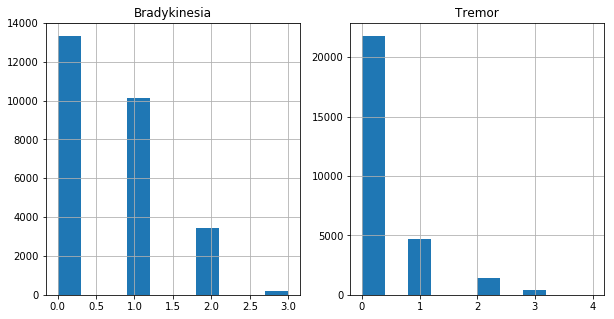

In [11]:
fig = plt.figure(figsize=(10,5))
fig.add_subplot(121)
Data['Bradykinesia'].hist()
plt.title('Bradykinesia')
fig.add_subplot(122)
Data['Tremor'].hist()
plt.title('Tremor')

How many instances of symptoms (>0) we have per subject and task

(<matplotlib.text.Text at 0x109bb1160>, <matplotlib.text.Text at 0x11253e630>)

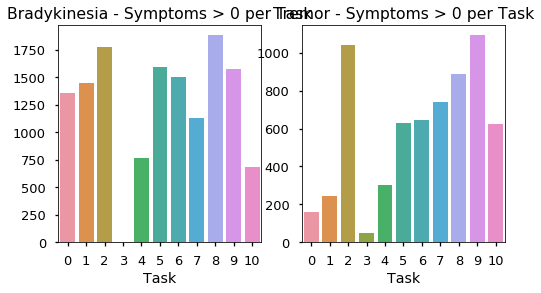

In [11]:
BradP=[]; TremorP=[]
for t in Data['Task'].unique(): 
    d = Data.loc[Data['Task']==t]
    BradP.append(sum(d['Bradykinesia'] > 0))
    TremorP.append(sum(d['Tremor'] > 0))

fig = plt.figure(figsize=(8,4))
fig.add_subplot(121)
sns.barplot(x=np.arange(len(BradP)),y=BradP)
plt.title('Bradykinesia - Symptoms > 0 per Task'), plt.xlabel('Task')
fig.add_subplot(122)
sns.barplot(x=np.arange(len(TremorP)),y=TremorP)
plt.title('Tremor - Symptoms > 0 per Task'), plt.xlabel('Task')


(<matplotlib.text.Text at 0x1128d7518>, <matplotlib.text.Text at 0x103230c88>)

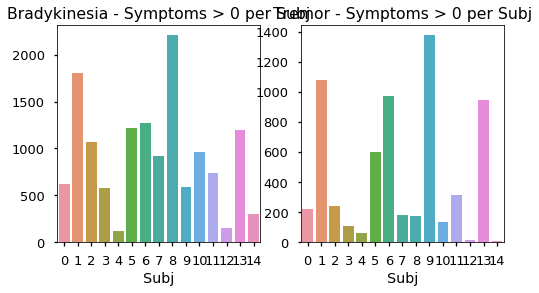

In [12]:
BradP=[]; TremorP=[]
for t in Data['Subject'].unique():
    d = Data.loc[Data['Subject']==t]
    BradP.append(sum(d['Bradykinesia'] > 0))
    TremorP.append(sum(d['Tremor'] > 0))

fig = plt.figure(figsize=(8,4))
fig.add_subplot(121)
sns.barplot(x=np.arange(len(BradP)),y=BradP)
plt.title('Bradykinesia - Symptoms > 0 per Subj'), plt.xlabel('Subj')
fig.add_subplot(122)
sns.barplot(x=np.arange(len(TremorP)),y=TremorP)
plt.title('Tremor - Symptoms > 0 per Subj'), plt.xlabel('Subj')


## Organize target scores into array

In [141]:
symptom = 'Bradykinesia'
# symptom = 'Tremor'

In [142]:
#rows with symptoms 
indp = ((Data[symptom]>0))
indp = indp.values

In [143]:
print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

Rows w Bradykinesia 13734/28486 = 0.48


# PCA on features to visualize subjects with symptom


In [144]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [145]:
#standardize features
X = Data.iloc[:,7:]
X_std = StandardScaler().fit_transform(X)
print(X.shape)

(28486, 28)


total explained variance ratio (first 10 components): 0.725
[ 0.20130721  0.12796938  0.10234457  0.06513069  0.04054553  0.04000015
  0.03956027  0.03633961  0.03596475  0.03580299]


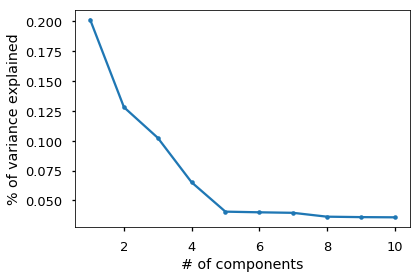

In [146]:
%matplotlib inline
nC = 10
pca = PCA(n_components=nC)
Xpca = pca.fit(X_std).transform(X_std)
# Percentage of variance explained for each components
print('total explained variance ratio (first %d components): %.3f'%(nC, pca.explained_variance_ratio_[0:nC].sum()))
print(pca.explained_variance_ratio_[:10])
ax = plt.plot(range(1,nC+1),pca.explained_variance_ratio_,'.-')
plt.xlabel('# of components')
plt.ylabel('% of variance explained')

In [147]:
Xpca.shape

(28486, 10)

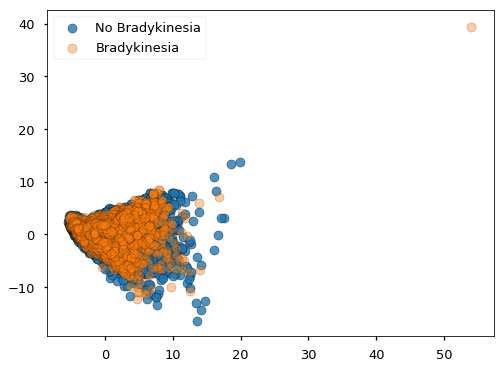

In [148]:
sns.set_context('talk')
fig = plt.figure(figsize=(8,6))
plt.scatter(Xpca[~indp,0],Xpca[~indp,1],cmap=plt.cm.Set1,edgecolors='k',alpha=0.8,label='No '+symptom)
plt.scatter(Xpca[indp,0],Xpca[indp,1],cmap=plt.cm.Set1,edgecolors='k',alpha=0.4,label=symptom)
plt.legend()

### PCA on a subject basis

total explained variance ratio (first 10 components): 0.769
total explained variance ratio (first 10 components): 0.742
total explained variance ratio (first 10 components): 0.741
total explained variance ratio (first 10 components): 0.735
total explained variance ratio (first 10 components): 0.767
total explained variance ratio (first 10 components): 0.746
total explained variance ratio (first 10 components): 0.741
total explained variance ratio (first 10 components): 0.732
total explained variance ratio (first 10 components): 0.737
total explained variance ratio (first 10 components): 0.748
total explained variance ratio (first 10 components): 0.741
total explained variance ratio (first 10 components): 0.751
total explained variance ratio (first 10 components): 0.757
total explained variance ratio (first 10 components): 0.736
total explained variance ratio (first 10 components): 0.767


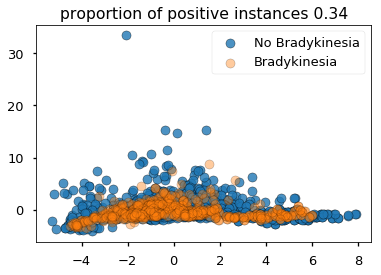

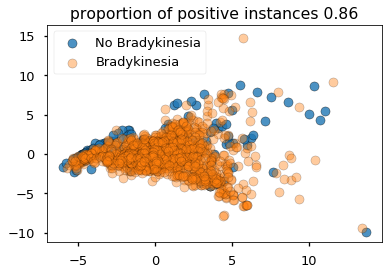

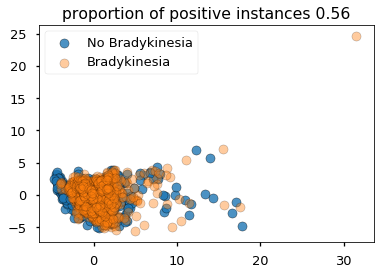

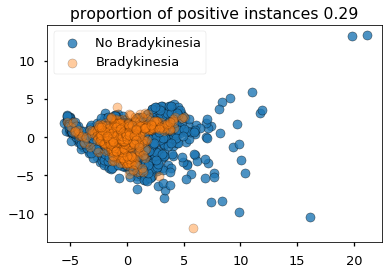

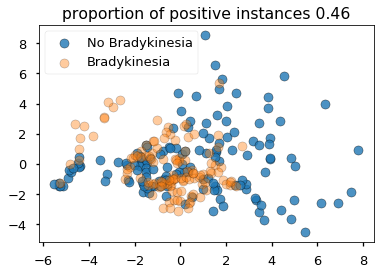

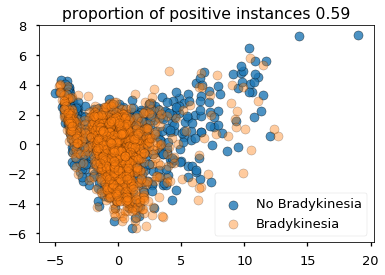

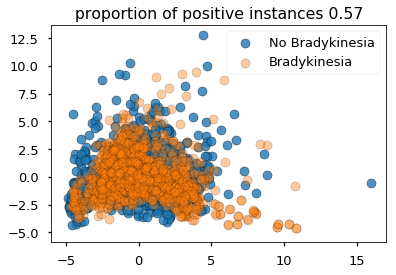

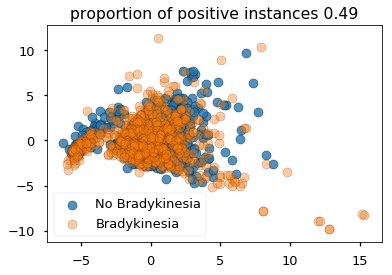

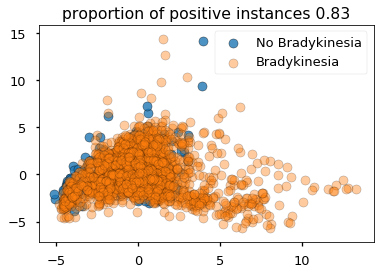

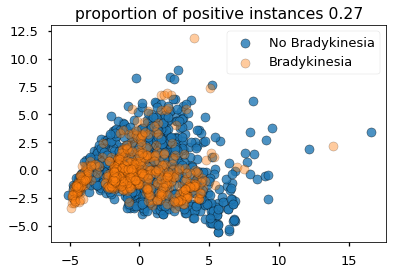

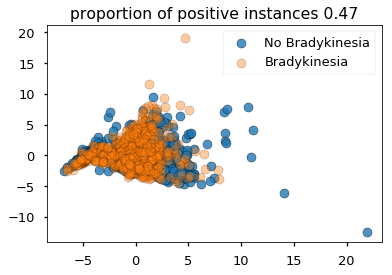

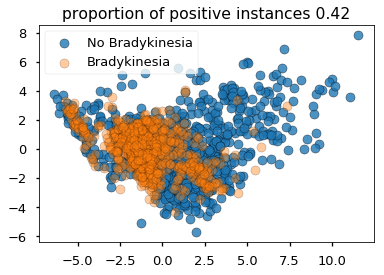

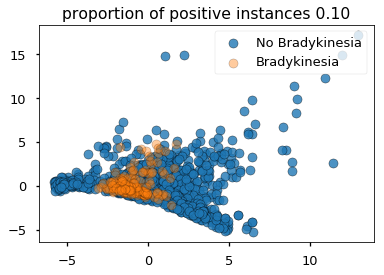

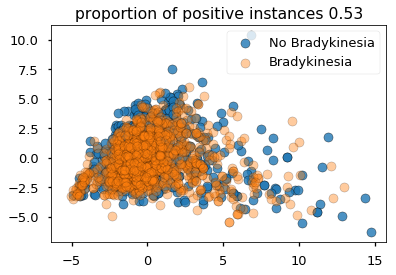

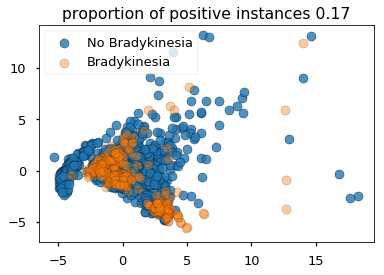

In [149]:
nC = 10

for s in Data.Subject.unique():
    ds = Data.loc[Data.Subject==s] 
    Xs = ds.iloc[:,7:] #features data
    Xs_std = StandardScaler().fit_transform(Xs)
    indp = ((ds[symptom]>0)) #rows with symptoms
    indp = indp.values
    #transform data (PCA)
    pca = PCA(n_components=nC)
    Xpca = pca.fit(Xs_std).transform(Xs_std)
    print('total explained variance ratio (first %d components): %.3f'%(nC, pca.explained_variance_ratio_[0:nC].sum()))
#     print(pca.explained_variance_ratio_[:10])
    plt.figure()
    plt.scatter(Xpca[~indp,0],Xpca[~indp,1],cmap=plt.cm.Set1,edgecolors='k',alpha=0.8,label='No '+symptom)
    plt.scatter(Xpca[indp,0],Xpca[indp,1],cmap=plt.cm.Set1,edgecolors='k',alpha=0.4,label=symptom)
    plt.legend()
    plt.title('proportion of positive instances %.2f'%(sum(indp)/len(ds)))


### Correlation between features
- If the signal is high-pass filtered (mean 0), remove RMS (std deviation is equivalent)

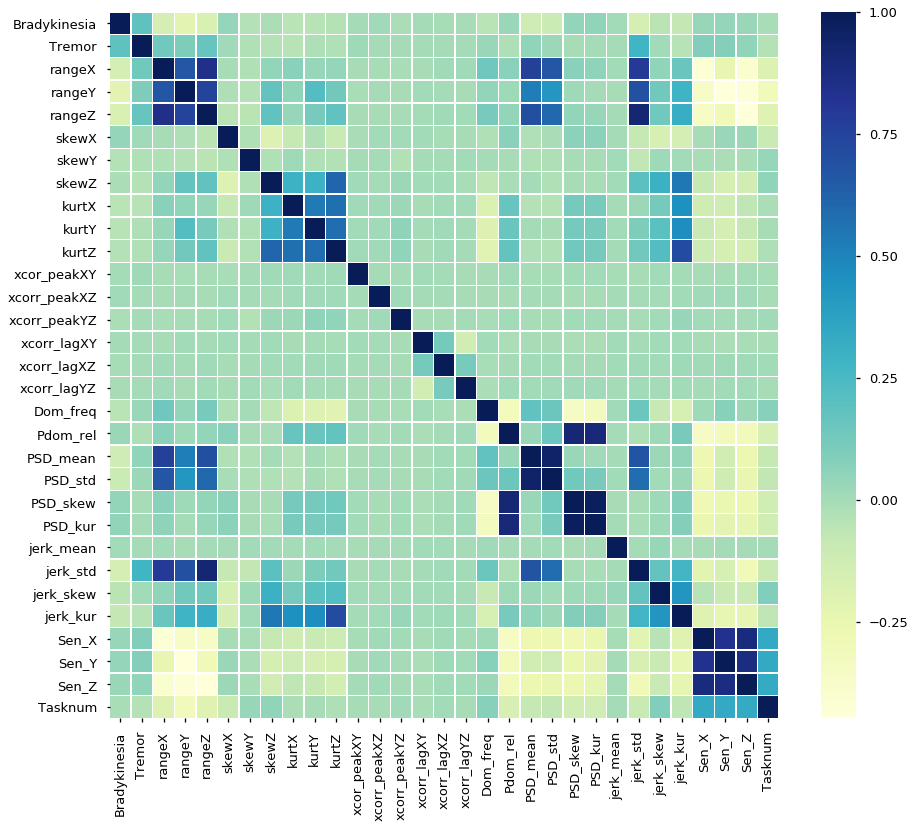

In [406]:
f = Data.iloc[:,5:]
plt.figure(figsize=(15,13))
sns.heatmap(f.corr(),cmap="YlGnBu",linewidths=.5)

In [402]:
le = LabelEncoder()
Data['Tasknum'] = le.fit_transform(Data.Task)

In [404]:
Data.Tasknum.unique()

array([ 3,  4,  6,  7,  8,  9, 10,  0,  1,  2,  5])

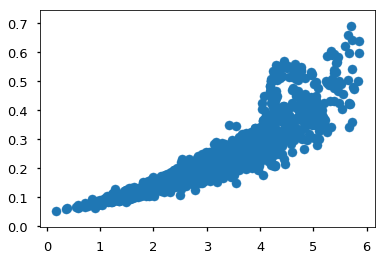

In [121]:
plt.scatter(f.PSD_skew,f.Pdom_rel)

In [122]:
# f.corr()

# Fit some classifiers to data

In [23]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn import preprocessing
from sklearn import neighbors, linear_model
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.linear_model import ElasticNetCV, LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix

## Leave one visit out (on all subjects)
train on all sessions, predict on left out session 


### Bradykinesia

In [116]:
le = LabelEncoder()

#standardize features (should be done in the CV loop)
X = Data.iloc[:,7:]
X_std = StandardScaler().fit_transform(X)

for symptom in ['Bradykinesia']:

    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

    models = [RandomForestClassifier(n_estimators=100,random_state=2)]          
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    groups = Data.Visit.as_matrix()

    res,res_group = LOSOCV(Data,X_std,y,groups,models)


Rows w Bradykinesia 13734/28486 = 0.48
Training Random Forest

Subj/Visit 0, prec=0.821, rec=0.630, Spec=0.774, auroc=0.769

Subj/Visit 1, prec=0.735, rec=0.753, Spec=0.787, auroc=0.848

Subj/Visit 2, prec=0.656, rec=0.755, Spec=0.726, auroc=0.827

Subj/Visit 3, prec=0.755, rec=0.650, Spec=0.779, auroc=0.800

Subj/Visit 4, prec=0.701, rec=0.741, Spec=0.755, auroc=0.823

Subj/Visit 5, prec=0.734, rec=0.698, Spec=0.798, auroc=0.833

Subj/Visit 6, prec=0.628, rec=0.596, Spec=0.657, auroc=0.687
f1_test=0.701+/-0.039, prec=0.719+/-0.059, rec=0.689+/-0.060, auprc=0.782+/-0.051


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


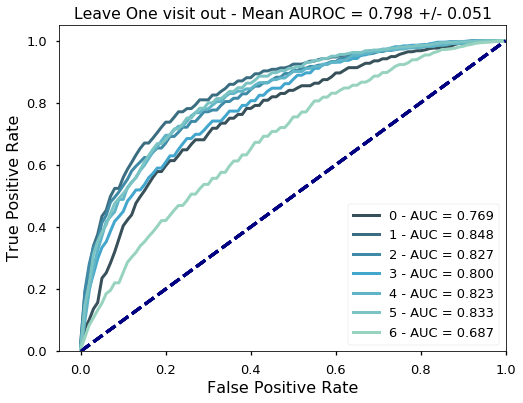

In [109]:
current_palette=sns.color_palette("GnBu_d", len(aurocall))
plt.figure(figsize=(8,6))
aurocall = res_group['Random Forest']['auroc']
for v in range(len(aurocall)):
    
    AX=plot_roc(res_group['Random Forest']['tpr'][v],res_group['Random Forest']['fpr'][v],aurocall[v],ax=None,plotname=v,col=current_palette[v])
plt.title('Leave One visit out - Mean AUROC = %.3f +/- %.3f'%(np.mean(aurocall),np.std(aurocall)))

### Tremor

In [114]:
le = LabelEncoder()

#standardize features (should be done in the CV loop)
X = Data.iloc[:,7:]
X_std = StandardScaler().fit_transform(X)

for symptom in ['Tremor']:

    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

    models = [RandomForestClassifier(n_estimators=100,random_state=2)]          
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    groups = Data.Visit.as_matrix()

    res,res_group = LOSOCV(Data,X_std,y,groups,models)


Rows w Tremor 6421/28486 = 0.23
Training Random Forest

Subj/Visit 0, prec=0.840, rec=0.238, Spec=0.974, auroc=0.802

Subj/Visit 1, prec=0.787, rec=0.426, Spec=0.975, auroc=0.866

Subj/Visit 2, prec=0.757, rec=0.511, Spec=0.967, auroc=0.886

Subj/Visit 3, prec=0.779, rec=0.259, Spec=0.975, auroc=0.816

Subj/Visit 4, prec=0.834, rec=0.367, Spec=0.981, auroc=0.859

Subj/Visit 5, prec=0.743, rec=0.392, Spec=0.966, auroc=0.844

Subj/Visit 6, prec=0.632, rec=0.372, Spec=0.947, auroc=0.808
f1_test=0.488+/-0.080, prec=0.767+/-0.065, rec=0.367+/-0.087, auprc=0.655+/-0.048


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


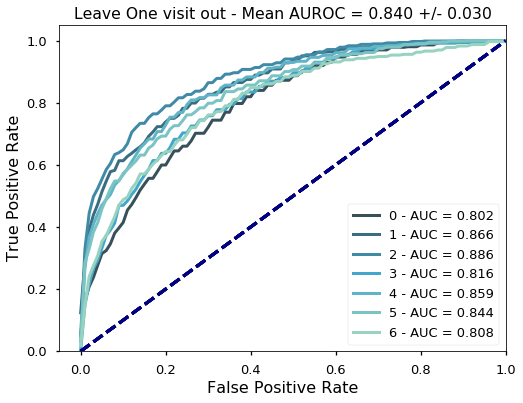

In [115]:
current_palette=sns.color_palette("GnBu_d", len(aurocall))
plt.figure(figsize=(8,6))
aurocall = res_group['Random Forest']['auroc']
for v in range(len(aurocall)):
    
    AX=plot_roc(res_group['Random Forest']['tpr'][v],res_group['Random Forest']['fpr'][v],aurocall[v],ax=None,plotname=v,col=current_palette[v])
plt.title('Leave One visit out - Mean AUROC = %.3f +/- %.3f'%(np.mean(aurocall),np.std(aurocall)))

## LOSO CV

In [20]:
t1=time.time()
res_all = pd.DataFrame()

#standardize features (should be done in the CV loop)
X = Data.iloc[:,7:]
X_std = StandardScaler().fit_transform(X)

for symptom in ['Bradykinesia']:
    
    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

    models = [RandomForestClassifier(n_estimators=100,random_state=2)]          
#           XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    groups = Data.Subject.as_matrix()

    res,res_group = LOSOCV(Data,X_std,y,groups,models)
    res_all = pd.concat((res_all,res))
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

Rows w Bradykinesia 13734/28486 = 0.48
Training Random Forest

Subj/Visit 0, prec=0.384, rec=0.392, Spec=0.675, auroc=0.557

Subj/Visit 1, prec=0.911, rec=0.526, Spec=0.694, auroc=0.685

Subj/Visit 2, prec=0.711, rec=0.677, Spec=0.654, auroc=0.730

Subj/Visit 3, prec=0.493, rec=0.920, Spec=0.613, auroc=0.859

Subj/Visit 4, prec=0.511, rec=0.563, Spec=0.540, auroc=0.561

Subj/Visit 5, prec=0.698, rec=0.517, Spec=0.677, auroc=0.651

Subj/Visit 6, prec=0.641, rec=0.542, Spec=0.593, auroc=0.580

Subj/Visit 7, prec=0.664, rec=0.744, Spec=0.643, auroc=0.773

Subj/Visit 8, prec=0.844, rec=0.425, Spec=0.615, auroc=0.564

Subj/Visit 9, prec=0.310, rec=0.480, Spec=0.599, auroc=0.559

Subj/Visit 10, prec=0.676, rec=0.631, Spec=0.732, auroc=0.743

Subj/Visit 11, prec=0.597, rec=0.442, Spec=0.789, auroc=0.684

Subj/Visit 12, prec=0.168, rec=0.581, Spec=0.694, auroc=0.708

Subj/Visit 13, prec=0.541, rec=0.396, Spec=0.616, auroc=0.519

Subj/Visit 14, prec=0.235, rec=0.508, Spec=0.655, auroc=0.654
f1_

In [21]:
np.unique(groups)

array([1004, 1016, 1018, 1019, 1020, 1024, 1029, 1030, 1032, 1038, 1044,
       1046, 1047, 1049, 1051])

In [31]:
le = LabelEncoder()
auprcall = res_group['Random Forest']['auprc']
aurocall = res_group['Random Forest']['auroc']
subj = le.fit_transform(np.unique(groups))

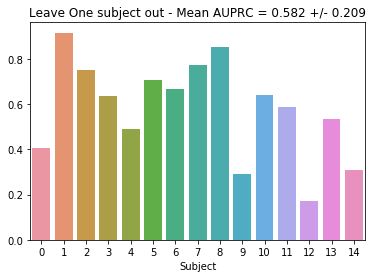

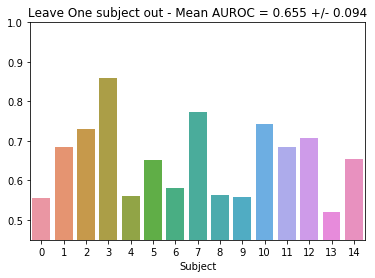

In [32]:
# plt.figure()
# ax=sns.barplot(x=np.arange(len(np.unique(subj))),y=f1all)
# plt.title('f1 score')
plt.figure()
ax=sns.barplot(x=np.arange(len(np.unique(subj))),y=auprcall)
plt.title('AUPRC')
plt.xlabel('Subject')
plt.title('Leave One subject out - Mean AUPRC = %.3f +/- %.3f'%(np.mean(auprcall),np.std(auprcall)))
plt.figure()
ax=sns.barplot(x=np.arange(len(np.unique(subj))),y=aurocall)
plt.title('AUROC')
plt.xlabel('Subject')
plt.ylim([0.45,1.])
plt.title('Leave One subject out - Mean AUROC = %.3f +/- %.3f'%(np.mean(aurocall),np.std(aurocall)))

### Tremor

In [174]:
t1=time.time()
res_all = pd.DataFrame()

#standardize features (should be done in the CV loop)
X = Data.iloc[:,7:]
X_std = StandardScaler().fit_transform(X)

for symptom in ['Tremor']:
    
    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

    models = [RandomForestClassifier(n_estimators=100,random_state=2)]          
#           XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    groups = Data.Subject.as_matrix()

    res,res_group = LOSOCV(Data,X_std,y,groups,models)
    res_all = pd.concat((res_all,res))
    
print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

Rows w Tremor 6421/28499 = 0.23
Training Random Forest

Subj/Visit 0, prec=0.258, rec=0.142, Spec=0.945, auroc=0.743

Subj/Visit 1, prec=0.667, rec=0.026, Spec=0.986, auroc=0.674

Subj/Visit 2, prec=0.464, rec=0.107, Spec=0.982, auroc=0.805

Subj/Visit 3, prec=0.217, rec=0.533, Spec=0.892, auroc=0.811

Subj/Visit 4, prec=0.457, rec=0.267, Spec=0.904, auroc=0.706

Subj/Visit 5, prec=0.345, rec=0.067, Spec=0.948, auroc=0.605

Subj/Visit 6, prec=0.601, rec=0.214, Spec=0.889, auroc=0.662

Subj/Visit 7, prec=0.731, rec=0.475, Spec=0.981, auroc=0.912

Subj/Visit 8, prec=0.435, rec=0.114, Spec=0.990, auroc=0.768

Subj/Visit 9, prec=0.963, rec=0.248, Spec=0.983, auroc=0.796

Subj/Visit 10, prec=0.550, rec=0.538, Spec=0.970, auroc=0.931

Subj/Visit 11, prec=0.048, rec=0.010, Spec=0.960, auroc=0.321

Subj/Visit 12, prec=0.000, rec=0.000, Spec=0.972, auroc=0.682

Subj/Visit 13, prec=0.810, rec=0.468, Spec=0.920, auroc=0.814

Subj/Visit 14, prec=0.029, rec=0.167, Spec=0.981, auroc=0.941
f1_test=0.

In [192]:
auprcall = res_group['Random Forest']['auprc']
aurocall = auprcall = res_group['Random Forest']['auroc']
subj = le.fit_transform(np.unique(groups))

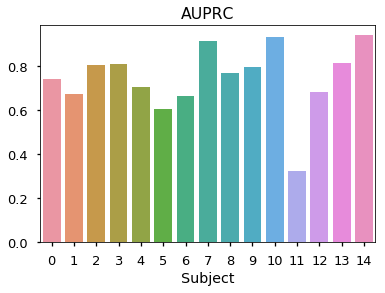

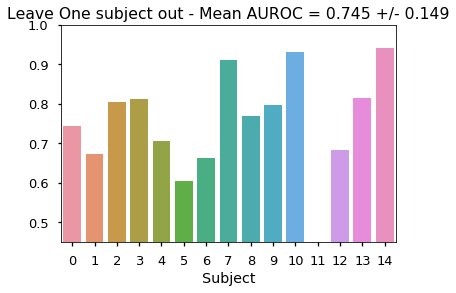

In [193]:
plt.figure()
ax=sns.barplot(x=subj,y=auprcall)
plt.title('AUPRC')
plt.xlabel('Subject')
plt.figure()
ax=sns.barplot(x=subj,y=aurocall)
plt.title('AUROC')
plt.xlabel('Subject')
plt.ylim([0.45,1.])
plt.title('Leave One subject out - Mean AUROC = %.3f +/- %.3f'%(np.mean(aurocall),np.std(aurocall)))

## Personal models - Leave one visit out

Bradykinesia

In [123]:
symptom = 'Bradykinesia'
le = LabelEncoder()
res_all = pd.DataFrame(data=None,index=None)
#train on all sessions, predict on left out session for each patient
for s in Data.Subject.unique():
    print('Subject %s'%s)
    ds = Data.loc[Data.Subject==s]
    indp = (ds[symptom]>0).values
    y = indp.astype(int) #target 
    X = ds.iloc[:,7:]
    X_std = StandardScaler().fit_transform(X) #standardize input data
    models = [RandomForestClassifier(n_estimators=100,random_state=2)]#,XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    groups = le.fit_transform(ds.Visit)
    if len(np.unique(groups))<2:
        continue
    res,res_group = LOSOCV(ds,X_std,y,groups,models)
    res.index = res.index+s
    res_all=pd.concat((res_all,res))


Subject 1004
Training Random Forest

Subj/Visit 0, prec=0.809, rec=0.202, Spec=0.649, auroc=0.542

Subj/Visit 1, prec=0.200, rec=0.104, Spec=0.903, auroc=0.622

Subj/Visit 2, prec=0.182, rec=0.250, Spec=0.882, auroc=0.818

Subj/Visit 3, prec=0.744, rec=0.587, Spec=0.873, auroc=0.815

Subj/Visit 4, prec=0.356, rec=0.615, Spec=0.875, auroc=0.871

Subj/Visit 5, prec=0.707, rec=0.475, Spec=0.939, auroc=0.841

Subj/Visit 6, prec=0.761, rec=0.586, Spec=0.884, auroc=0.809
f1_test=0.430+/-0.196, prec=0.537+/-0.259, rec=0.403+/-0.197, auprc=0.545+/-0.263
Subject 1016
Training Random Forest

Subj/Visit 0, prec=0.913, rec=0.989, Spec=0.265, auroc=0.865

Subj/Visit 1, prec=0.867, rec=0.996, Spec=0.302, auroc=0.853

Subj/Visit 2, prec=0.874, rec=0.983, Spec=0.312, auroc=0.882

Subj/Visit 3, prec=0.941, rec=0.985, Spec=0.433, auroc=0.901

Subj/Visit 4, prec=0.876, rec=1.000, Spec=0.370, auroc=0.752

Subj/Visit 5, prec=0.914, rec=0.967, Spec=0.419, auroc=0.815

Subj/Visit 6, prec=0.868, rec=0.907, Sp

/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)



Subj/Visit 2, prec=0.000, rec=0.000, Spec=0.982, auroc=nan

Subj/Visit 3, prec=1.000, rec=0.235, Spec=1.000, auroc=0.887


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)



Subj/Visit 4, prec=0.000, rec=0.000, Spec=0.992, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)



Subj/Visit 5, prec=0.000, rec=0.000, Spec=0.995, auroc=nan

Subj/Visit 6, prec=0.000, rec=0.000, Spec=1.000, auroc=nan
f1_test=0.098+/-0.157, prec=0.244+/-0.394, rec=0.062+/-0.098, auprc=0.716+/-0.072
Subject 1049
Training Random Forest

Subj/Visit 0, prec=0.856, rec=0.874, Spec=0.834, auroc=0.914

Subj/Visit 1, prec=0.887, rec=0.904, Spec=0.866, auroc=0.957

Subj/Visit 2, prec=0.891, rec=0.912, Spec=0.862, auroc=0.942

Subj/Visit 3, prec=0.932, rec=0.778, Spec=0.931, auroc=0.942

Subj/Visit 4, prec=0.894, rec=0.879, Spec=0.877, auroc=0.952

Subj/Visit 5, prec=0.874, rec=0.879, Spec=0.845, auroc=0.918

Subj/Visit 6, prec=0.536, rec=0.588, Spec=0.544, auroc=0.590
f1_test=0.833+/-0.113, prec=0.838+/-0.125, rec=0.831+/-0.107, auprc=0.892+/-0.129
Subject 1051
Training Random Forest

Subj/Visit 0, prec=1.000, rec=0.176, Spec=1.000, auroc=0.865

Subj/Visit 1, prec=0.714, rec=0.435, Spec=0.981, auroc=0.889

Subj/Visit 2, prec=0.714, rec=0.714, Spec=0.982, auroc=0.980

Subj/Visit 3, prec=1.00

In [124]:
subj=le.fit_transform(res_all.index.values)

Results by subject averaged over 6 visits

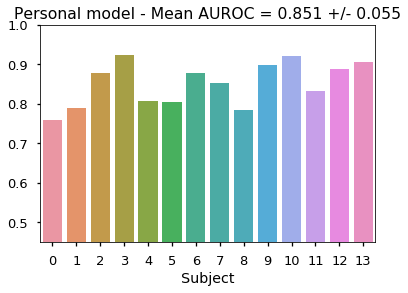

In [125]:
ax=sns.barplot(x=subj,y=res_all.auroc.values)
plt.title('AUROC')
plt.xlabel('Subject')
plt.ylim([0.45,1.])
plt.title('Personal model - Mean AUROC = %.3f +/- %.3f'%(res_all.auroc.mean(),res_all.auroc.std()))

Results by visit averaged over subjects

/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


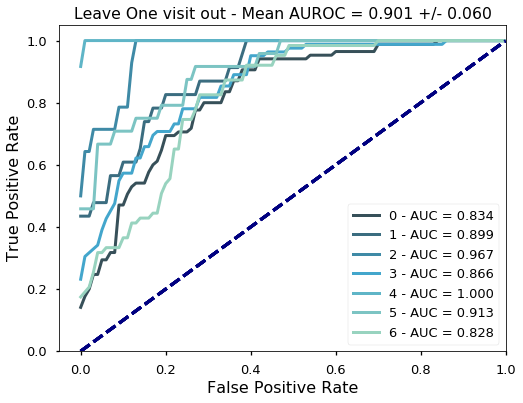

In [24]:
plt.figure(figsize=(8,6))
aurocall = res_group['Random Forest']['auroc']
current_palette=sns.color_palette("GnBu_d", len(aurocall))
for v in range(len(aurocall)):
    
    AX=plot_roc(res_group['Random Forest']['tpr'][v],res_group['Random Forest']['fpr'][v],aurocall[v],ax=None,plotname=v,col=current_palette[v])
plt.title('Leave One visit out - Mean AUROC = %.3f +/- %.3f'%(np.mean(aurocall),np.std(aurocall)))

In [126]:
# res_all.boxplot()
# plt.title('Personal Models - Results across subjects')

Tremor

There are visit with no positive or negative examples. This makes problematic to compute scores

In [29]:
symptom = 'Tremor'
le = LabelEncoder()
res_all = pd.DataFrame(data=None,index=None)
#train on all sessions, predict on left out session for each patient
for s in Data.Subject.unique():
    print('Subject %s'%s)
    ds = Data.loc[Data.Subject==s]
    indp = (ds[symptom]>0).values
    y = indp.astype(int) #target 
    X = ds.iloc[:,7:]
    X_std = StandardScaler().fit_transform(X) #standardize input data
    models = [RandomForestClassifier(n_estimators=100,random_state=2)]#,XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    groups = le.fit_transform(ds.Visit)
    if len(np.unique(groups))<2:
        continue
    res,res_group = LOSOCV(ds,X_std,y,groups,models)
    res.index = res.index+s
    res_all=pd.concat((res_all,res))


Subject 1004
Training Random Forest


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc=0.678


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)



Subj/Visit 1, prec=0.000, rec=0.000, Spec=0.996, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)



Subj/Visit 2, prec=0.000, rec=0.000, Spec=0.996, auroc=nan

Subj/Visit 3, prec=0.000, rec=0.000, Spec=0.992, auroc=0.947


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)



Subj/Visit 4, prec=0.000, rec=0.000, Spec=0.996, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)



Subj/Visit 5, prec=0.000, rec=0.000, Spec=0.992, auroc=nan

Subj/Visit 6, prec=0.222, rec=0.118, Spec=0.966, auroc=0.807
f1_test=0.022+/-0.054, prec=0.032+/-0.078, rec=0.017+/-0.041, auprc=0.455+/-0.241
Subject 1016
Training Random Forest

Subj/Visit 0, prec=0.784, rec=0.893, Spec=0.750, auroc=0.785

Subj/Visit 1, prec=0.937, rec=0.881, Spec=0.901, auroc=0.955

Subj/Visit 2, prec=0.938, rec=0.858, Spec=0.905, auroc=0.963

Subj/Visit 3, prec=0.887, rec=0.867, Spec=0.837, auroc=0.939

Subj/Visit 4, prec=0.879, rec=0.904, Spec=0.814, auroc=0.931

Subj/Visit 5, prec=0.954, rec=0.885, Spec=0.917, auroc=0.970


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)



Subj/Visit 6, prec=0.000, rec=0.000, Spec=0.347, auroc=nan
f1_test=0.761+/-0.312, prec=0.768+/-0.318, rec=0.756+/-0.309, auprc=0.910+/-0.123
Subject 1018
Training Random Forest

Subj/Visit 0, prec=1.000, rec=0.099, Spec=1.000, auroc=0.803

Subj/Visit 1, prec=1.000, rec=0.867, Spec=1.000, auroc=0.991

Subj/Visit 2, prec=1.000, rec=0.947, Spec=1.000, auroc=1.000

Subj/Visit 3, prec=1.000, rec=0.422, Spec=1.000, auroc=0.926

Subj/Visit 4, prec=1.000, rec=0.360, Spec=1.000, auroc=0.850

Subj/Visit 5, prec=1.000, rec=0.947, Spec=1.000, auroc=1.000

Subj/Visit 6, prec=0.909, rec=0.870, Spec=0.992, auroc=0.998
f1_test=0.724+/-0.279, prec=0.987+/-0.032, rec=0.645+/-0.319, auprc=0.853+/-0.150
Subject 1019
Training Random Forest


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc=0.558

Subj/Visit 1, prec=1.000, rec=0.917, Spec=1.000, auroc=1.000

Subj/Visit 2, prec=1.000, rec=0.833, Spec=1.000, auroc=1.000


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)



Subj/Visit 3, prec=0.000, rec=0.000, Spec=0.957, auroc=nan

Subj/Visit 4, prec=0.909, rec=0.714, Spec=0.996, auroc=0.999

Subj/Visit 5, prec=1.000, rec=0.643, Spec=1.000, auroc=1.000

Subj/Visit 6, prec=1.000, rec=0.045, Spec=1.000, auroc=0.820
f1_test=0.505+/-0.417, prec=0.701+/-0.445, rec=0.450+/-0.386, auprc=0.764+/-0.344
Subject 1020
Subject 1024
Training Random Forest

Subj/Visit 0, prec=0.919, rec=0.121, Spec=0.977, auroc=0.806

Subj/Visit 1, prec=0.343, rec=0.364, Spec=0.903, auroc=0.800

Subj/Visit 2, prec=0.111, rec=1.000, Spec=0.775, auroc=0.892

Subj/Visit 3, prec=0.865, rec=0.245, Spec=0.950, auroc=0.723

Subj/Visit 4, prec=0.467, rec=0.400, Spec=0.925, auroc=0.853

Subj/Visit 5, prec=0.088, rec=0.500, Spec=0.882, auroc=0.867

Subj/Visit 6, prec=0.459, rec=0.519, Spec=0.858, auroc=0.787
f1_test=0.316+/-0.119, prec=0.465+/-0.304, rec=0.450+/-0.259, auprc=0.458+/-0.290
Subject 1029
Training Random Forest

Subj/Visit 0, prec=1.000, rec=0.357, Spec=1.000, auroc=0.957

Subj/Vis

/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc=0.954

Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc=nan

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 3, prec=0.000, rec=0.000, Spec=1.000, auroc=0.775

Subj/Visit 4, prec=0.000, rec=0.000, Spec=1.000, auroc=nan

Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc=nan

Subj/Visit 6, prec=0.000, rec=0.000, Spec=1.000, auroc=nan
f1_test=0.000+/-0.000, prec=0.000+/-0.000, rec=0.000+/-0.000, auprc=0.223+/-0.026
Subject 1049
Training Random Forest

Subj/Visit 0, prec=0.904, rec=0.746, Spec=0.890, auroc=0.888

Subj/Visit 1, prec=0.894, rec=0.880, Spec=0.921, auroc=0.959

Subj/Visit 2, prec=0.827, rec=0.909, Spec=0.877, auroc=0.959

Subj/Visit 3, prec=0.902, rec=0.505, Spec=0.972, auroc=0.916

Subj/Visit 4, prec=0.843, rec=0.898, Spec=0.921, auroc=0.968

Subj/Visit 5, prec=0.805, rec=0.817, Spec=0.859, auroc=0.921

Subj/Visit 6, prec=0.869, rec=0.570, Spec=0.925, auroc=0.805
f1_test=0.798+/-0.087, prec=0.863+/-0.036, rec=0.761+/-0.151, auprc=0.902+/-0.048
Subject 1051
Training Random Forest

Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc=nan

Subj/Visit 1, prec=0.000, r

/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:72: RuntimeWarning: Mean of empty slice
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:78: RuntimeWarning: Mean of empty slice


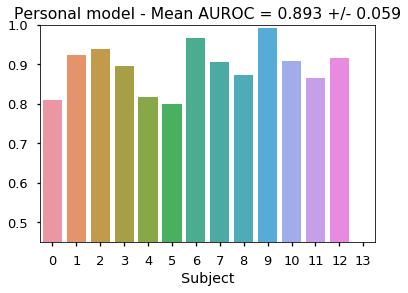

In [30]:
ax=sns.barplot(x=subj,y=res_all.auroc.values)
plt.title('AUROC')
plt.xlabel('Subject')
plt.ylim([0.45,1.])
plt.title('Personal model - Mean AUROC = %.3f +/- %.3f'%(res_all.auroc.mean(),res_all.auroc.std()))

In [37]:
res_group['Random Forest']['auroc']

[nan, nan, nan, nan, nan, nan]

/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


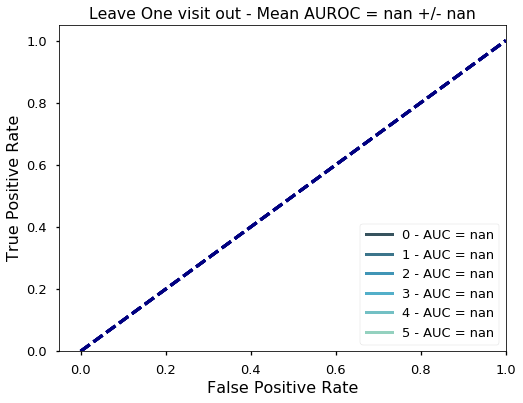

In [31]:
plt.figure(figsize=(8,6))
aurocall = res_group['Random Forest']['auroc']
current_palette=sns.color_palette("GnBu_d", len(aurocall))
for v in range(len(aurocall)):
    
    AX=plot_roc(res_group['Random Forest']['tpr'][v],res_group['Random Forest']['fpr'][v],aurocall[v],ax=None,plotname=v,col=current_palette[v])
plt.title('Leave One visit out - Mean AUROC = %.3f +/- %.3f'%(np.mean(aurocall),np.std(aurocall)))

## Personal models - Semi-supervised

Three options:
1) Consider all data from visit 5 as regular observation (score 0 or ON state); treat 1s and 0s as symptom or no-symptom from other visits

per task, then normalize and compare with trend in clincal scores over time
2) Consider only 0s from visit 5 as regular observations. Compute 

In [132]:
Data.Visit.unique()

array(['2 Weeks: Time 0', '2 Weeks: Time 30', '2 Weeks: Time 60',
       '2 Weeks: Time 90', '2 Weeks: Time 120', '2 Weeks: Time 150',
       '4 Weeks'], dtype=object)

In [385]:
#train SVM on ON State (visit 5)
#The nu parameter, also known as the margin of the One-Class SVM, 
#corresponds to the probability of finding a new, but regular, observation outside the frontier.
symptom = 'Bradykinesia'
scaler = StandardScaler()
#select patient
s = 1004
ds_train = Data.loc[(Data.Subject==s)&(Data.Visit=='2 Weeks: Time 150')]
ds_test = Data.loc[(Data.Subject==s)&(Data.Visit!='2 Weeks: Time 150')]
# ds_train = Data.loc[(Data.Subject==s)&(Data.Visit!='4 Weeks')]
# ds_test = Data.loc[(Data.Subject==s)&(Data.Visit=='4 Weeks')]

X_train = ds_train[ds_train[symptom]==0].iloc[:,7:].values #features for 0 scores
X_train = scaler.fit_transform(X_train)

model=svm.OneClassSVM(nu=0.1,kernel='rbf')
model.fit(X_train)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='auto', kernel='rbf',
      max_iter=-1, nu=0.1, random_state=None, shrinking=True, tol=0.001,
      verbose=False)

In [386]:
y_pred=model.predict(X_train)

(array([  25.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,  197.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

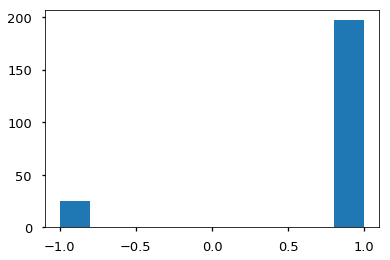

In [387]:
plt.hist(y_pred)

In [388]:
X_test0=scaler.transform(ds_test[ds_test[symptom]==0].iloc[:,7:].values)
X_test1=scaler.transform(ds_test[ds_test[symptom]>=1].iloc[:,7:].values)
# X_test2=scaler.transform(ds_test[ds_test[symptom]>=2].iloc[:,7:].values)
print(X_test0.shape)
print(X_test1.shape)
# print(X_test2.shape)

(943, 28)
(598, 28)


In [389]:
z0 = model.decision_function(X_test0).ravel()
z1 = model.decision_function(X_test1).ravel()
# z2 = model.decision_function(X_test2).ravel()

In [390]:
print(np.min(z0))
print(np.max(z0))
print(np.median(z0))
print(np.std(z0))
print(np.percentile(z0,75))

-1.47056137717
1.36272928218
0.365986804328
0.594108071307
0.666473926422


In [391]:
print(np.min(z1))
print(np.max(z1))
print(np.median(z1))
print(np.std(z1))
print(np.percentile(z1,75))

-1.47056137717
1.15909859467
0.478897905026
0.479375764812
0.704353151742


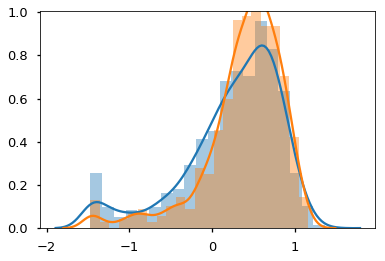

In [392]:
sns.distplot(z0)
sns.distplot(z1)

In [366]:
y_pred0 = model.predict(X_test0)
y_pred1 = model.predict(X_test1)
err0 = np.sum(y_pred0<1)/len(y_pred0)
err1 = np.sum(y_pred1>-1)/len(y_pred1)
print(err0)
print(err1)

0.261930010604
0.854515050167


(array([   4.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,  107.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

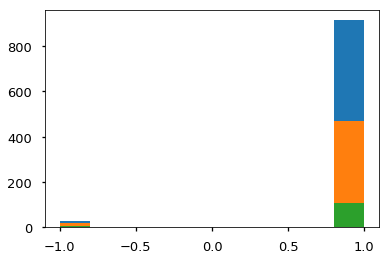

In [235]:
#predict
plt.hist(model.predict(X_test0))    
plt.hist(model.predict(X_test1))    
plt.hist(model.predict(X_test2))    

In [164]:
X_test0 = ds_test[ds_test[sy]]==0

X_test1 = ds_test[symptom]==1

(222, 28)

## Personal models - Leave one task out

Bradykinesia

In [42]:
symptom = 'Bradykinesia'
le = LabelEncoder()
res_all = pd.DataFrame(data=None,index=None)
#train on all sessions, predict on left out session for each patient
for s in Data.Subject.unique():
    print('Subject %s'%s)
    ds = Data.loc[Data.Subject==s]
    indp = (ds[symptom]>0).values
    y = indp.astype(int) #target 
    X = ds.iloc[:,7:]
    X_std = StandardScaler().fit_transform(X) #standardize input data
    models = [RandomForestClassifier(n_estimators=100,random_state=2)]#,XGBClassifier()]
    model_name = ['Random Forest']#,'XGB']
    models = list(zip(models,model_name))
    groups = le.fit_transform(ds.Task)
    if len(np.unique(groups))<2:
        continue
    res,res_group = LOSOCV(ds,X_std,y,groups,models)
    res.index = res.index+s
    res_all=pd.concat((res_all,res))


Subject 1004
Training Random Forest

Subj/Visit 0, prec=0.474, rec=0.360, Spec=0.778, auroc=0.529

Subj/Visit 1, prec=0.654, rec=0.500, Spec=0.929, auroc=0.791

Subj/Visit 2, prec=0.714, rec=0.208, Spec=0.978, auroc=0.686

Subj/Visit 3, prec=0.708, rec=0.642, Spec=0.873, auroc=0.790

Subj/Visit 4, prec=0.907, rec=0.765, Spec=0.967, auroc=0.968

Subj/Visit 5, prec=1.000, rec=0.242, Spec=1.000, auroc=0.846

Subj/Visit 6, prec=1.000, rec=0.007, Spec=1.000, auroc=0.761


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)



Subj/Visit 7, prec=0.000, rec=0.000, Spec=0.816, auroc=nan

Subj/Visit 8, prec=0.170, rec=0.900, Spec=0.143, auroc=0.524

Subj/Visit 9, prec=0.014, rec=0.083, Spec=0.117, auroc=0.015

Subj/Visit 10, prec=0.611, rec=0.195, Spec=0.785, auroc=0.372
f1_test=0.346+/-0.259, prec=0.568+/-0.348, rec=0.355+/-0.294, auprc=0.561+/-0.260
Subject 1016
Training Random Forest

Subj/Visit 0, prec=1.000, rec=0.960, Spec=nan, auroc=nan

Subj/Visit 1, prec=1.000, rec=0.927, Spec=nan, auroc=nan

Subj/Visit 2, prec=1.000, rec=0.939, Spec=nan, auroc=nan

Subj/Visit 3, prec=0.934, rec=1.000, Spec=0.000, auroc=0.444

Subj/Visit 4, prec=1.000, rec=1.000, Spec=nan, auroc=nan

Subj/Visit 5, prec=0.412, rec=0.921, Spec=0.000, auroc=0.390

Subj/Visit 6, prec=0.867, rec=1.000, Spec=0.000, auroc=0.670


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)



Subj/Visit 7, prec=0.000, rec=0.000, Spec=0.000, auroc=nan

Subj/Visit 8, prec=0.500, rec=1.000, Spec=0.000, auroc=0.396

Subj/Visit 9, prec=1.000, rec=0.995, Spec=nan, auroc=nan

Subj/Visit 10, prec=1.000, rec=1.000, Spec=nan, auroc=nan
f1_test=0.822+/-0.295, prec=0.792+/-0.322, rec=0.886+/-0.282, auprc=0.871+/-0.227
Subject 1018
Training Random Forest

Subj/Visit 0, prec=0.319, rec=0.974, Spec=0.090, auroc=0.746

Subj/Visit 1, prec=0.741, rec=0.571, Spec=0.465, auroc=0.509

Subj/Visit 2, prec=0.819, rec=0.677, Spec=0.365, auroc=0.567

Subj/Visit 3, prec=0.989, rec=0.968, Spec=0.989, auroc=0.998

Subj/Visit 4, prec=0.979, rec=1.000, Spec=0.978, auroc=1.000

Subj/Visit 5, prec=0.719, rec=0.836, Spec=0.514, auroc=0.711

Subj/Visit 6, prec=1.000, rec=0.053, Spec=1.000, auroc=0.552


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)



Subj/Visit 7, prec=0.000, rec=0.000, Spec=0.383, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)



Subj/Visit 8, prec=0.000, rec=0.000, Spec=0.011, auroc=nan

Subj/Visit 9, prec=0.736, rec=0.401, Spec=0.172, auroc=0.241

Subj/Visit 10, prec=0.532, rec=0.989, Spec=0.129, auroc=0.661
f1_test=0.538+/-0.344, prec=0.621+/-0.351, rec=0.588+/-0.394, auprc=0.785+/-0.139
Subject 1019
Training Random Forest

Subj/Visit 0, prec=0.000, rec=0.000, Spec=0.873, auroc=0.622

Subj/Visit 1, prec=0.312, rec=0.076, Spec=0.953, auroc=0.652

Subj/Visit 2, prec=0.389, rec=0.175, Spec=0.947, auroc=0.702

Subj/Visit 3, prec=1.000, rec=0.926, Spec=1.000, auroc=1.000

Subj/Visit 4, prec=1.000, rec=0.989, Spec=1.000, auroc=1.000

Subj/Visit 5, prec=0.889, rec=0.242, Spec=0.982, auroc=0.660

Subj/Visit 6, prec=1.000, rec=0.010, Spec=1.000, auroc=0.483


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)



Subj/Visit 7, prec=0.000, rec=0.000, Spec=0.985, auroc=nan

Subj/Visit 8, prec=0.000, rec=0.000, Spec=0.989, auroc=0.654

Subj/Visit 9, prec=0.500, rec=0.015, Spec=0.992, auroc=0.767

Subj/Visit 10, prec=0.182, rec=0.036, Spec=0.932, auroc=0.541
f1_test=0.255+/-0.359, prec=0.479+/-0.404, rec=0.224+/-0.354, auprc=0.488+/-0.317
Subject 1020
Training Random Forest

Subj/Visit 0, prec=0.000, rec=0.000, Spec=0.538, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)



Subj/Visit 1, prec=1.000, rec=0.357, Spec=1.000, auroc=0.745

Subj/Visit 2, prec=0.000, rec=0.000, Spec=0.875, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)



Subj/Visit 3, prec=1.000, rec=1.000, Spec=nan, auroc=nan

Subj/Visit 4, prec=1.000, rec=0.885, Spec=nan, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)



Subj/Visit 5, prec=0.000, rec=0.000, Spec=0.500, auroc=nan

Subj/Visit 6, prec=0.476, rec=0.833, Spec=0.083, auroc=0.375


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 7, prec=0.000, rec=0.000, Spec=0.583, auroc=nan

Subj/Visit 8, prec=0.000, rec=0.000, Spec=1.000, auroc=0.586


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)



Subj/Visit 9, prec=0.000, rec=0.000, Spec=nan, auroc=nan

Subj/Visit 10, prec=0.000, rec=0.000, Spec=0.615, auroc=nan
f1_test=0.279+/-0.389, prec=0.316+/-0.440, rec=0.280+/-0.398, auprc=0.805+/-0.217
Subject 1024
Training Random Forest

Subj/Visit 0, prec=0.906, rec=0.827, Spec=0.190, auroc=0.496

Subj/Visit 1, prec=0.667, rec=0.640, Spec=0.415, auroc=0.525

Subj/Visit 2, prec=0.388, rec=0.769, Spec=0.267, auroc=0.558

Subj/Visit 3, prec=0.538, rec=0.163, Spec=0.956, auroc=0.537

Subj/Visit 4, prec=0.295, rec=0.867, Spec=0.814, auroc=0.907

Subj/Visit 5, prec=1.000, rec=0.830, Spec=nan, auroc=nan

Subj/Visit 6, prec=1.000, rec=0.419, Spec=1.000, auroc=0.758


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)



Subj/Visit 7, prec=0.000, rec=0.000, Spec=0.261, auroc=nan

Subj/Visit 8, prec=0.466, rec=0.827, Spec=0.432, auroc=0.625

Subj/Visit 9, prec=0.964, rec=0.834, Spec=0.538, auroc=0.820

Subj/Visit 10, prec=1.000, rec=0.975, Spec=nan, auroc=nan
f1_test=0.609+/-0.289, prec=0.657+/-0.329, rec=0.650+/-0.303, auprc=0.723+/-0.263
Subject 1029
Training Random Forest

Subj/Visit 0, prec=0.476, rec=0.598, Spec=0.500, auroc=0.541

Subj/Visit 1, prec=0.548, rec=0.293, Spec=0.797, auroc=0.562

Subj/Visit 2, prec=0.338, rec=0.373, Spec=0.629, auroc=0.478

Subj/Visit 3, prec=0.872, rec=0.945, Spec=0.148, auroc=0.640

Subj/Visit 4, prec=0.887, rec=0.980, Spec=0.269, auroc=0.673


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)



Subj/Visit 5, prec=0.000, rec=0.000, Spec=0.161, auroc=nan

Subj/Visit 6, prec=0.846, rec=0.786, Spec=0.444, auroc=0.665


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)



Subj/Visit 7, prec=0.000, rec=0.000, Spec=0.337, auroc=nan

Subj/Visit 8, prec=0.253, rec=1.000, Spec=0.192, auroc=0.861

Subj/Visit 9, prec=1.000, rec=0.740, Spec=nan, auroc=nan

Subj/Visit 10, prec=1.000, rec=0.432, Spec=nan, auroc=nan
f1_test=0.525+/-0.319, prec=0.565+/-0.363, rec=0.559+/-0.351, auprc=0.747+/-0.227
Subject 1030
Training Random Forest

Subj/Visit 0, prec=0.238, rec=0.455, Spec=0.761, auroc=0.662

Subj/Visit 1, prec=0.952, rec=0.118, Spec=0.983, auroc=0.566

Subj/Visit 2, prec=0.051, rec=0.636, Spec=0.299, auroc=0.526

Subj/Visit 3, prec=0.808, rec=0.756, Spec=0.868, auroc=0.902

Subj/Visit 4, prec=1.000, rec=0.791, Spec=1.000, auroc=1.000

Subj/Visit 5, prec=0.545, rec=0.977, Spec=0.340, auroc=0.794

Subj/Visit 6, prec=1.000, rec=0.438, Spec=1.000, auroc=0.774


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)



Subj/Visit 7, prec=0.000, rec=0.000, Spec=0.892, auroc=nan

Subj/Visit 8, prec=0.497, rec=0.978, Spec=0.011, auroc=0.340

Subj/Visit 9, prec=0.562, rec=0.065, Spec=0.870, auroc=0.306

Subj/Visit 10, prec=0.679, rec=0.379, Spec=0.833, auroc=0.731
f1_test=0.441+/-0.293, prec=0.576+/-0.343, rec=0.508+/-0.334, auprc=0.631+/-0.282
Subject 1032
Training Random Forest

Subj/Visit 0, prec=1.000, rec=0.974, Spec=nan, auroc=nan

Subj/Visit 1, prec=1.000, rec=0.946, Spec=nan, auroc=nan

Subj/Visit 2, prec=1.000, rec=0.986, Spec=nan, auroc=nan

Subj/Visit 3, prec=0.621, rec=0.926, Spec=0.470, auroc=0.763

Subj/Visit 4, prec=0.871, rec=0.852, Spec=0.763, auroc=0.886

Subj/Visit 5, prec=1.000, rec=1.000, Spec=nan, auroc=nan

Subj/Visit 6, prec=1.000, rec=0.645, Spec=nan, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)



Subj/Visit 7, prec=0.000, rec=0.000, Spec=0.000, auroc=nan

Subj/Visit 8, prec=0.500, rec=1.000, Spec=0.000, auroc=0.547

Subj/Visit 9, prec=0.826, rec=0.855, Spec=0.184, auroc=0.573

Subj/Visit 10, prec=0.854, rec=1.000, Spec=0.000, auroc=0.609
f1_test=0.797+/-0.274, prec=0.788+/-0.297, rec=0.835+/-0.283, auprc=0.887+/-0.162
Subject 1038
Training Random Forest

Subj/Visit 0, prec=0.000, rec=0.000, Spec=1.000, auroc=nan

Subj/Visit 1, prec=1.000, rec=0.043, Spec=1.000, auroc=0.631

Subj/Visit 2, prec=0.333, rec=0.259, Spec=0.948, auroc=0.599

Subj/Visit 3, prec=0.862, rec=0.714, Spec=0.886, auroc=0.834

Subj/Visit 4, prec=0.910, rec=0.635, Spec=0.938, auroc=0.856

Subj/Visit 5, prec=0.833, rec=0.096, Spec=0.977, auroc=0.720

Subj/Visit 6, prec=0.466, rec=0.773, Spec=0.152, auroc=0.440


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)



Subj/Visit 7, prec=0.000, rec=0.000, Spec=0.954, auroc=nan

Subj/Visit 8, prec=0.200, rec=0.011, Spec=0.966, auroc=0.621

Subj/Visit 9, prec=0.000, rec=0.000, Spec=0.973, auroc=0.307

Subj/Visit 10, prec=0.190, rec=0.148, Spec=0.897, auroc=0.515
f1_test=0.259+/-0.290, prec=0.436+/-0.379, rec=0.244+/-0.295, auprc=0.485+/-0.299
Subject 1044
Training Random Forest

Subj/Visit 0, prec=0.667, rec=0.933, Spec=0.641, auroc=0.866

Subj/Visit 1, prec=0.748, rec=0.506, Spec=0.829, auroc=0.732

Subj/Visit 2, prec=0.734, rec=0.617, Spec=0.848, auroc=0.821

Subj/Visit 3, prec=1.000, rec=0.978, Spec=1.000, auroc=1.000

Subj/Visit 4, prec=1.000, rec=0.959, Spec=1.000, auroc=1.000

Subj/Visit 5, prec=0.260, rec=1.000, Spec=0.186, auroc=0.662


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 6, prec=0.000, rec=0.000, Spec=1.000, auroc=0.288


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)



Subj/Visit 7, prec=0.000, rec=0.000, Spec=0.680, auroc=nan

Subj/Visit 8, prec=0.739, rec=0.882, Spec=0.688, auroc=0.894

Subj/Visit 9, prec=0.931, rec=0.633, Spec=0.917, auroc=0.830

Subj/Visit 10, prec=0.850, rec=0.814, Spec=0.815, auroc=0.904
f1_test=0.620+/-0.330, prec=0.630+/-0.354, rec=0.666+/-0.350, auprc=0.776+/-0.233
Subject 1046
Training Random Forest


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)



Subj/Visit 0, prec=0.000, rec=0.000, Spec=0.967, auroc=nan

Subj/Visit 1, prec=0.000, rec=0.000, Spec=0.967, auroc=0.345


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)



Subj/Visit 2, prec=0.000, rec=0.000, Spec=0.994, auroc=nan

Subj/Visit 3, prec=1.000, rec=0.984, Spec=nan, auroc=nan

Subj/Visit 4, prec=1.000, rec=0.866, Spec=nan, auroc=nan

Subj/Visit 5, prec=0.400, rec=0.417, Spec=0.754, auroc=0.444

Subj/Visit 6, prec=1.000, rec=0.172, Spec=1.000, auroc=0.668


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)



Subj/Visit 7, prec=0.000, rec=0.000, Spec=0.908, auroc=nan

Subj/Visit 8, prec=0.295, rec=0.765, Spec=0.290, auroc=0.649

Subj/Visit 9, prec=0.200, rec=0.107, Spec=0.695, auroc=0.309

Subj/Visit 10, prec=0.286, rec=0.077, Spec=0.969, auroc=0.676
f1_test=0.301+/-0.346, prec=0.380+/-0.402, rec=0.308+/-0.367, auprc=0.538+/-0.343
Subject 1047
Training Random Forest


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)



Subj/Visit 0, prec=0.000, rec=0.000, Spec=0.918, auroc=nan

Subj/Visit 1, prec=0.000, rec=0.000, Spec=0.973, auroc=0.807

Subj/Visit 2, prec=0.000, rec=0.000, Spec=1.000, auroc=nan

Subj/Visit 3, prec=1.000, rec=0.519, Spec=1.000, auroc=0.979

Subj/Visit 4, prec=1.000, rec=0.692, Spec=1.000, auroc=0.990

Subj/Visit 5, prec=0.000, rec=0.000, Spec=0.986, auroc=0.952


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 6, prec=0.000, rec=0.000, Spec=1.000, auroc=0.544


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)



Subj/Visit 7, prec=0.000, rec=0.000, Spec=0.905, auroc=nan

Subj/Visit 8, prec=0.000, rec=0.000, Spec=1.000, auroc=nan

Subj/Visit 9, prec=1.000, rec=0.037, Spec=1.000, auroc=0.603

Subj/Visit 10, prec=0.286, rec=0.080, Spec=0.966, auroc=0.796
f1_test=0.154+/-0.285, prec=0.299+/-0.437, rec=0.121+/-0.233, auprc=0.500+/-0.319
Subject 1049
Training Random Forest

Subj/Visit 0, prec=0.929, rec=0.714, Spec=0.925, auroc=0.913

Subj/Visit 1, prec=0.731, rec=0.779, Spec=0.713, auroc=0.821

Subj/Visit 2, prec=0.599, rec=0.965, Spec=0.513, auroc=0.865

Subj/Visit 3, prec=0.804, rec=0.925, Spec=0.830, auroc=0.909

Subj/Visit 4, prec=0.826, rec=0.724, Spec=0.879, auroc=0.908

Subj/Visit 5, prec=1.000, rec=0.413, Spec=nan, auroc=nan

Subj/Visit 6, prec=1.000, rec=0.888, Spec=nan, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)



Subj/Visit 7, prec=0.000, rec=0.000, Spec=0.607, auroc=nan

Subj/Visit 8, prec=0.352, rec=0.291, Spec=0.623, auroc=0.492

Subj/Visit 9, prec=0.952, rec=0.667, Spec=0.953, auroc=0.857

Subj/Visit 10, prec=0.881, rec=0.692, Spec=0.877, auroc=0.866
f1_test=0.667+/-0.262, prec=0.734+/-0.296, rec=0.642+/-0.281, auprc=0.845+/-0.155
Subject 1051
Training Random Forest


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)



Subj/Visit 0, prec=0.000, rec=0.000, Spec=0.984, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 1, prec=0.000, rec=0.000, Spec=1.000, auroc=0.626


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)



Subj/Visit 2, prec=0.000, rec=0.000, Spec=0.985, auroc=nan

Subj/Visit 3, prec=0.714, rec=0.128, Spec=0.986, auroc=0.860

Subj/Visit 4, prec=0.833, rec=0.104, Spec=0.994, auroc=0.864


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 5, prec=0.000, rec=0.000, Spec=1.000, auroc=0.491


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 6, prec=0.000, rec=0.000, Spec=1.000, auroc=0.738

Subj/Visit 7, prec=0.000, rec=0.000, Spec=1.000, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)



Subj/Visit 8, prec=0.000, rec=0.000, Spec=0.792, auroc=nan


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)



Subj/Visit 9, prec=0.000, rec=0.000, Spec=1.000, auroc=0.781

Subj/Visit 10, prec=0.000, rec=0.000, Spec=1.000, auroc=0.523
f1_test=0.037+/-0.078, prec=0.141+/-0.300, rec=0.021+/-0.045, auprc=0.427+/-0.202


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


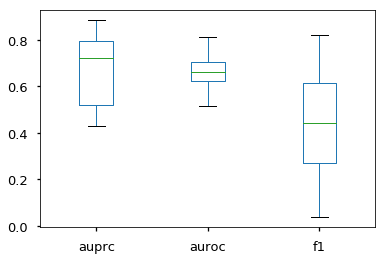

In [47]:
#average across tasks - distribution shown across subjects
res_all.plot(kind='box')

## Try with k-fold CV

In [98]:
t1=time.time()

for symptom in ['Tremor','Bradykinesia']:
    
    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

    models = [RandomForestClassifier(n_estimators=100,random_state=2),          
          XGBClassifier()]
    model_name = ['Random Forest','XGB']
    models = list(zip(models,model_name))

    f1_fold_clf, auc_fold_clf, cmats = trainmodel_Kfold(X_std,y,models,nfolds=5,balance=False)
    
print('Elapsed time = %.3f'%(round(time.time()-t1)))    

Rows w Tremor 6421/28499 = 0.23
Random Forest
f1_train=1.000+/-0.000, f1_test=0.556+/-0.008, prec=0.843+/-0.016, rec=0.415+/-0.010, auprc=0.736+/-0.005
[[4294  121]
 [ 743  541]]
XGB
f1_train=0.468+/-0.006, f1_test=0.447+/-0.015, prec=0.758+/-0.010, rec=0.317+/-0.014, auprc=0.637+/-0.005
[[4279  136]
 [ 843  441]]
Rows w Bradykinesia 13734/28499 = 0.48
Random Forest
f1_train=1.000+/-0.000, f1_test=0.758+/-0.005, prec=0.773+/-0.004, rec=0.743+/-0.008, auprc=0.850+/-0.003
[[2338  615]
 [ 731 2015]]
XGB
f1_train=0.721+/-0.002, f1_test=0.703+/-0.009, prec=0.693+/-0.008, rec=0.714+/-0.011, auprc=0.758+/-0.008
[[2040  913]
 [ 823 1923]]


In [109]:
t1=time.time()
for symptom in ['Tremor','Bradykinesia']:
    
    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    print('\nRows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

    models = [RandomForestClassifier(n_estimators=100,random_state=2),          
          XGBClassifier()]
    model_name = ['Random Forest','XGB']
    models = list(zip(models,model_name))

    f1_fold_clf, auc_fold_clf, cmats = trainmodel_Kfold(X_std,y,models,nfolds=5,balance=True)

print('Elapsed time = %.3f'%(round(time.time()-t1)))


Rows w Tremor 6421/28499 = 0.23
Npos = 5137, Nneg = 5137
Random Forest
f1_train=1.000+/-0.000, f1_test=0.613+/-0.007, prec=0.505+/-0.010, rec=0.781+/-0.010, auprc=0.698+/-0.009
[[3401 1014]
 [ 291  993]]
Npos = 5137, Nneg = 5137
XGB
f1_train=0.784+/-0.004, f1_test=0.570+/-0.010, prec=0.458+/-0.010, rec=0.755+/-0.017, auprc=0.627+/-0.006
[[3259 1156]
 [ 302  982]]

Rows w Bradykinesia 13734/28499 = 0.48
Npos = 10988, Nneg = 10988
Random Forest
f1_train=1.000+/-0.000, f1_test=0.763+/-0.009, prec=0.758+/-0.009, rec=0.767+/-0.010, auprc=0.848+/-0.005
[[2245  708]
 [ 672 2074]]
Npos = 10988, Nneg = 10988
XGB
f1_train=0.735+/-0.001, f1_test=0.707+/-0.009, prec=0.678+/-0.008, rec=0.739+/-0.012, auprc=0.757+/-0.009
[[1941 1012]
 [ 767 1979]]
Elapsed time = 131.000


## CNN on rawdata

In [18]:
# data = pd.read_hdf('../FeatureMatrix/DataRawclips.hdf5')

In [18]:
data = pd.read_hdf('../FeatureMatrix/DataRawcl')

In [12]:
# data = pd.read_hdf('../FeatureMatrix/DataRawClipsUnfiltered.hdf5')

In [19]:
data.head()

,Subject,Visit,Task,Location,Bradykinesia,Tremor,Dyskinesia,acc_xyz,gyr_xyz
0,1004,2 Weeks: Time 0,Motor #2: Walking,dorsal_hand_left,1.0,0.0,0.0,"[[0.00442182590312, -0.0200148763835, -0.01990...","[[2.41092545968, 28.7174792096, 1.80056458381]..."
1,1004,2 Weeks: Time 0,Motor #2: Walking,dorsal_hand_left,1.0,0.0,0.0,"[[-0.0607082544856, -0.0905657087803, 0.064953...","[[-54.4136720836, 12.9701686122, 110.688944839..."
2,1004,2 Weeks: Time 0,Motor #2: Walking,dorsal_hand_left,1.0,0.0,0.0,"[[0.220442267724, 0.152858651212, 0.1146350880...","[[-45.2582589456, 7.66002899214, 38.7884336614..."
3,1004,2 Weeks: Time 0,Motor #2: Walking,dorsal_hand_left,1.0,0.0,0.0,"[[-0.000921648804147, -0.0425384594624, 0.1049...","[[-10.7118333715, -65.6443121996, 15.411612115..."
4,1004,2 Weeks: Time 0,Motor #2: Walking,dorsal_hand_left,1.0,0.0,0.0,"[[0.055472374389, 0.0319095435029, -0.09051654...","[[62.3483634699, 23.9566643778, -94.8805981537..."


In [20]:
data.Location.unique()

array(['dorsal_hand_left', 'dorsal_hand_right'], dtype=object)

In [21]:
len(data)

27805

Plot clips with symptoms

In [22]:
dataP=data[data.Bradykinesia>1]
dataN=data[data.Bradykinesia==0]

Subject                                                      1019
Visit                                           2 Weeks: Time 120
Task                         Motor #5: Alternating Hand Movements
Location                                        dorsal_hand_right
Bradykinesia                                                    0
Tremor                                                          0
Dyskinesia                                                      0
acc_xyz         [[0.87150408923, 0.0432566793599, -0.663815077...
gyr_xyz         [[-72.1751735714, -111.970702678, -30.97581445...
Name: 4, dtype: object


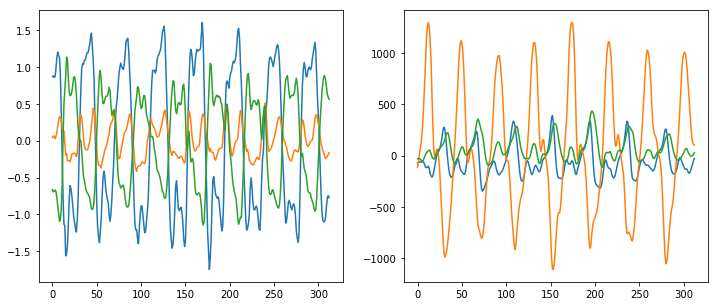

In [23]:
idx = np.random.choice(np.arange(len(dataP)),size=1)
d=dataN.iloc[int(idx)]
print(d)
fig=plt.figure(figsize=(12,5))
fig.add_subplot(121)
plt.plot(d.acc_xyz)
fig.add_subplot(122)
plt.plot(d.gyr_xyz)

In [107]:
# data['acclen']=data.apply()

In [24]:
#unpack clips, scores, subj and task data
le = LabelEncoder()
acc = data.acc_xyz.values
gyr = data.gyr_xyz.values
scores_brady = data.Bradykinesia
scores_tremor = data.Tremor
scores_dysk = data.Dyskinesia
task = le.fit_transform(data.Task)
visit = le.fit_transform(data.Visit)
subj = le.fit_transform(data.Subject)

### Resample data

In [25]:
#check clips with less than 313 samples and resample
la=[]; lg=[]
for i in range(len(acc)):
    la.append(acc[i].shape[0])
    lg.append(gyr[i].shape[0])

print(np.unique(lg))

#resample all clips to 313 samples (62.5 Hz)
# accres = []
num = 313
accres = np.zeros((len(acc),num,3) )
gyrres = np.zeros((len(gyr),num,3) )
for i in range(len(acc)):
    if len(acc[i]<num):
        accres[i,:,0] = resample(acc[i][:,0],num)
        accres[i,:,1] = resample(acc[i][:,1],num)
        accres[i,:,2] = resample(acc[i][:,2],num)
    else: 
        accres[i,:,:] = acc[i].copy()
        
    if len(gyr[i]<num):
        gyrres[i,:,0] = resample(gyr[i][:,0],num)
        gyrres[i,:,1] = resample(gyr[i][:,1],num)
        gyrres[i,:,2] = resample(gyr[i][:,2],num)
    else:
        gyrres[i,:,:] = acc[i].copy()

[297 298 299 300 301 302 303 304 305 306 307 308 309 310 311 312 313]


In [26]:
acc = accres
gyr = gyrres

In [27]:
def stdclipdata(X,plotdata=False):
    #standardize clips data by channel (for CNN)
    Xn = X.copy()
    x = np.reshape(X,(X.shape[0]*X.shape[1],X.shape[2]))
    m = np.mean(x,axis=0)
    s = np.std(x,axis=0)
    for c in range(X.shape[0]):
        for a in range(X.shape[2]):
            Xn[c,:,a]=(X[c,:,a]-m[a])/s[a]
    Xn.shape
    if plotdata:
        for i in range(0,5):
            print(np.mean(Xn[i],axis=0),np.std(X[i],axis=0))
            plt.plot(Xn[i])

    return Xn

In [28]:
accn = stdclipdata(acc,False)
gyrn = stdclipdata(gyr,False)

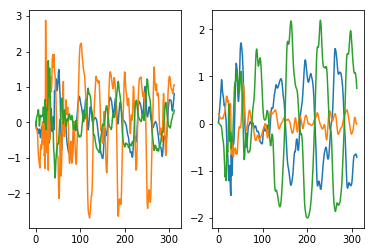

In [30]:
fig = plt.figure()
fig.add_subplot(121)
plt.plot(accn[0])
fig.add_subplot(122)
plt.plot(gyrn[0])

### Train CNN on bradykinesia data
* accelerometer only

In [31]:
# X = accn.copy()
X = np.concatenate((accn,gyrn),axis=-1) #use acc and gyro data
y = scores_brady.values
print(X.shape)
print(y.shape)

(27805, 313, 6)
(27805,)


In [32]:
#remove rows (tasks) for which bradykinesia scores do not exists
indok = np.where(~np.isnan(y))[0]
X = X[indok,:,:]
y = y[indok]
task = task[indok]
visit = visit[indok]
subj = subj[indok]

In [33]:
np.unique(task)

array([ 0,  1,  2,  3,  4,  5,  6,  8,  9, 10])

In [34]:
print(X.shape)
print(y.shape)
print(task.shape)
print(visit.shape)
print(subj.shape)

(26449, 313, 6)
(26449,)
(26449,)
(26449,)
(26449,)


In [35]:
#binarize labels
y[y>0] = 1

In [36]:
#load clips, standardize and split data into train and valid set
def prepare_data(X,y,network_type,balance=False):
    
    #standardize all data (note - should std training and apply on test)
#     Xn = stdclipdata(X)
#     Xn = X
    
    #perform a random train_valid split first to test approach
    inds = np.arange(0,len(y))
    X_train,X_valid,y_train,y_valid,inds_train,inds_valid = train_test_split(X,y,inds,test_size=0.2,stratify=task,random_state=32)
    print('X_train = ')
    print(X_train.shape)
    print('X_valid = ')
    print(X_valid.shape)
    
    #balance training dataset
    if balance:
        indsp = np.where(y_train==1)[0]
        indsn = np.random.choice(np.where(y_train==0)[0],size=round(1.5*len(indsp)),replace=False)
        inds = np.hstack((indsp,indsn))
        X_train=X_train[inds]
        y_train=y_train[inds]

    num_classes = 2 # 
    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_valid = keras.utils.to_categorical(y_valid, num_classes)
    
    #format data for specific network
    _, win_len, dim = X.shape
    print('reshaping data for different models ...')
    X_train, X_valid = _data_reshaping(X_train, X_valid, network_type)
    print('X_train = ')
    print(X_train.shape)

    return X_train,y_train,X_valid,y_valid,inds_train,inds_valid,win_len,dim

In [121]:
X_train,y_train,X_valid,y_valid,inds_train,inds_valid,win_len,dim = prepare_data(X,y,'CNN')

X_train = 
(21159, 313, 6)
X_valid = 
(5290, 313, 6)
reshaping data for different models ...
CNN
X_train = 
(21159, 6, 313, 1)


In [122]:
#swap axes to have channel as last dim
X_train = np.swapaxes(X_train,1,3)
X_valid = np.swapaxes(X_valid,1,3)
print(X_train.shape)

(21159, 1, 313, 6)


In [123]:
#specifying hyper-parameters
batch_size = 512 #1024
feat_map_num = 16
num_classes =2 

In [124]:
print('building the model ...')
model=Sequential()
model.add(Conv2D(filters=16, kernel_size=(1, 32),activation='relu',input_shape=(1, win_len, dim),padding='same'))
model.add(MaxPooling2D(pool_size=(1, 4)))
model.add(Conv2D(filters=16, kernel_size=(1, 16), activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(1, 6)))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

building the model ...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 1, 313, 16)        3088      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 1, 78, 16)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 78, 16)         4112      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 1, 13, 16)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 208)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                6688      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)              

In [125]:
print('model training ...')
epochs = 20
model.compile(loss=keras.losses.categorical_crossentropy,optimizer='adam',metrics=['accuracy'])
hist=model.fit(X_train,y_train,batch_size,epochs,shuffle=True,validation_data=(X_valid,y_valid))

model training ...
Train on 21159 samples, validate on 5290 samples
Epoch 1/20
21159/21159 [==============================] - 14s - loss: 0.7126 - acc: 0.5068 - val_loss: 0.6869 - val_acc: 0.5694
Epoch 2/20
21159/21159 [==============================] - 14s - loss: 0.6801 - acc: 0.5605 - val_loss: 0.6577 - val_acc: 0.6284
Epoch 3/20
21159/21159 [==============================] - 14s - loss: 0.6463 - acc: 0.6243 - val_loss: 0.6088 - val_acc: 0.6631
Epoch 4/20
21159/21159 [==============================] - 15s - loss: 0.6128 - acc: 0.6653 - val_loss: 0.5815 - val_acc: 0.6951
Epoch 5/20
21159/21159 [==============================] - 17s - loss: 0.5870 - acc: 0.6911 - val_loss: 0.5641 - val_acc: 0.7042
Epoch 6/20
21159/21159 [==============================] - 15s - loss: 0.5646 - acc: 0.7136 - val_loss: 0.5371 - val_acc: 0.7187
Epoch 7/20
21159/21159 [==============================] - 13s - loss: 0.5385 - acc: 0.7368 - val_loss: 0.5191 - val_acc: 0.7357
Epoch 8/20
21159/21159 [============

In [126]:
print('model training ...')
epochs = 20
model.compile(loss=keras.losses.categorical_crossentropy,optimizer='adam',metrics=['accuracy'])
hist=model.fit(X_train,y_train,batch_size,epochs,shuffle=True,validation_data=(X_valid,y_valid))

model training ...
Train on 21159 samples, validate on 5290 samples
Epoch 1/20
21159/21159 [==============================] - 27s - loss: 0.4196 - acc: 0.8121 - val_loss: 0.4484 - val_acc: 0.7905
Epoch 2/20
21159/21159 [==============================] - 16s - loss: 0.3957 - acc: 0.8231 - val_loss: 0.4434 - val_acc: 0.7922
Epoch 3/20
21159/21159 [==============================] - 13s - loss: 0.3906 - acc: 0.8279 - val_loss: 0.4660 - val_acc: 0.7826
Epoch 4/20
21159/21159 [==============================] - 14s - loss: 0.3933 - acc: 0.8229 - val_loss: 0.4305 - val_acc: 0.8026
Epoch 5/20
21159/21159 [==============================] - 14s - loss: 0.3838 - acc: 0.8295 - val_loss: 0.4459 - val_acc: 0.7922
Epoch 6/20
21159/21159 [==============================] - 13s - loss: 0.3839 - acc: 0.8304 - val_loss: 0.4283 - val_acc: 0.8026
Epoch 7/20
21159/21159 [==============================] - 13s - loss: 0.3785 - acc: 0.8337 - val_loss: 0.4341 - val_acc: 0.7987
Epoch 8/20
21159/21159 [============

Unfitered

f1_test=0.811, Prec=0.784, Rec=0.839, auprc=0.900
[[1967  624]
 [ 434 2265]]
the mean f1 score:0.80


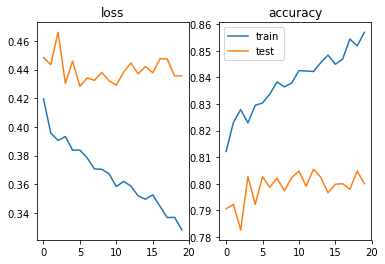

In [127]:
model_eval(X_valid,y_valid)

HP filtered data

f1_test=0.729, Prec=0.811, Rec=0.662, auprc=0.846
[[2173  418]
 [ 911 1788]]
the mean f1 score:0.75


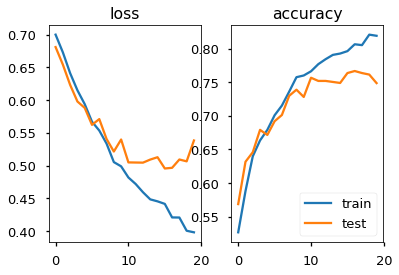

In [661]:
model_eval(X_valid,y_valid)

keep training

model training ...
Train on 21159 samples, validate on 5290 samples
Epoch 1/20
21159/21159 [==============================] - 7s - loss: 0.4250 - acc: 0.8030 - val_loss: 0.4631 - val_acc: 0.7811
Epoch 2/20
21159/21159 [==============================] - 7s - loss: 0.4036 - acc: 0.8145 - val_loss: 0.4652 - val_acc: 0.7784
Epoch 3/20
21159/21159 [==============================] - 7s - loss: 0.3991 - acc: 0.8138 - val_loss: 0.4816 - val_acc: 0.7715
Epoch 4/20
21159/21159 [==============================] - 7s - loss: 0.4012 - acc: 0.8128 - val_loss: 0.4740 - val_acc: 0.7792
Epoch 5/20
21159/21159 [==============================] - 7s - loss: 0.4048 - acc: 0.8125 - val_loss: 0.4813 - val_acc: 0.7733
Epoch 6/20
21159/21159 [==============================] - 7s - loss: 0.4010 - acc: 0.8173 - val_loss: 0.4697 - val_acc: 0.7767
Epoch 7/20
21159/21159 [==============================] - 7s - loss: 0.3956 - acc: 0.8160 - val_loss: 0.4750 - val_acc: 0.7762
Epoch 8/20
21159/21159 [===================

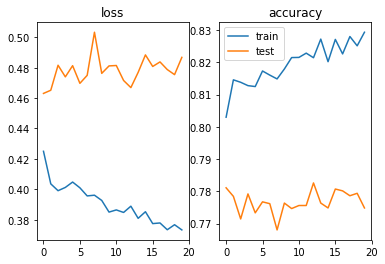

In [44]:
print('model training ...')
epochs = 20
model.compile(loss=keras.losses.categorical_crossentropy,optimizer='adam',metrics=['accuracy'])
hist=model.fit(X_train,y_train,batch_size,epochs,shuffle=True,validation_data=(X_valid,y_valid))
model_eval(X_valid,y_valid)

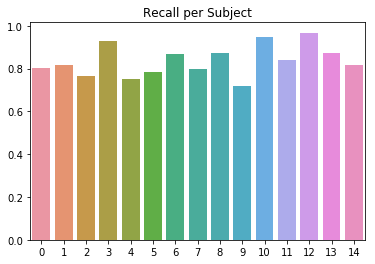

In [128]:
#recall rate per subject
y_pred = np.argmax(model.predict(X_valid),axis=1)
y_valid = np.argmax(y_valid,axis=1)
subj_valid=subj[inds_valid]

RecS = []
for s in np.unique(subj_valid):

    indS = np.where(subj_valid==s)
    ytrue_s = y_valid[indS]
    ypred_s = y_pred[indS]
    TP=sum(ypred_s[ytrue_s==1])
    P = sum(ytrue_s == 1)
    RecS.append(TP/P)
    
ax = sns.barplot(x=np.arange(len(RecS)),y=RecS)
plt.title('Recall per Subject')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

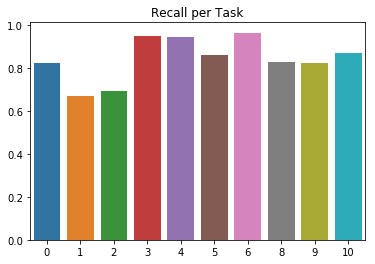

In [129]:
#recall rate per task
y_pred = np.argmax(model.predict(X_valid),axis=1)
# y_valid = np.argmax(y_valid,axis=1)
task_valid=task[inds_valid]

RecS = []
for s in np.unique(task_valid):

    indS = np.where(task_valid==s)
    ytrue_s = y_valid[indS]
    ypred_s = y_pred[indS]
    TP=sum(ypred_s[ytrue_s==1])
    P = sum(ytrue_s == 1)
    RecS.append(TP/P)
    
ax = sns.barplot(x=np.unique(task_valid),y=RecS)
plt.title('Recall per Task')
plt.xticks()

In [61]:
le = LabelEncoder()
taskcodes = le.fit_transform(data.Task)
taskcodes = np.unique(taskcodes)
tasknames = le.inverse_transform(taskcodes)

In [62]:
print(list(zip(taskcodes,tasknames)))

[(0, 'Motor #10: Drinking Water'), (1, 'Motor #11: Organizing Folder'), (2, 'Motor #12: Folding Towels'), (3, 'Motor #2: Walking'), (4, 'Motor #3: Walking while Counting'), (5, 'Motor #4: Finger to Nose'), (6, 'Motor #5: Alternating Hand Movements'), (7, 'Motor #6: Sit to Stand'), (8, 'Motor #7: Drawing on Paper'), (9, 'Motor #8: Typing on a Computer'), (10, 'Motor #9: Nuts and Bolts')]


In [63]:
indscorrect=inds_valid[y_valid==y_pred]
indswrong=inds_valid[y_valid!=y_pred]

In [64]:
len(indswrong)

1220

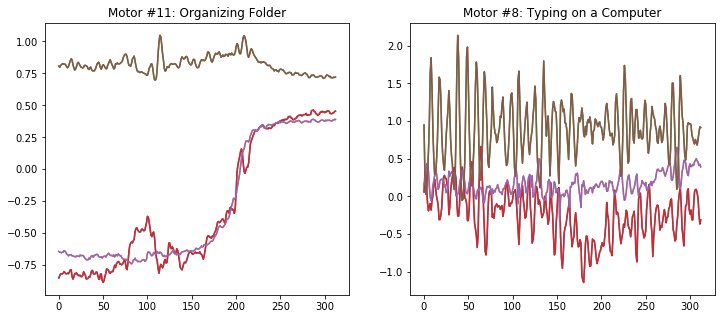

In [69]:
tasklist=(list(zip(taskcodes,tasknames)))
idx1 = np.random.choice(indswrong,size=1)
idx2 = np.random.choice(indscorrect,size=1)
fig=plt.figure(figsize=(12,5))
fig.add_subplot(121)
plt.plot(X[idx1][0])
plt.title(tasklist[int(task[idx1])][1])
fig.add_subplot(122)
plt.plot(X[idx2][0])
plt.title(tasklist[int(task[idx2])][1])

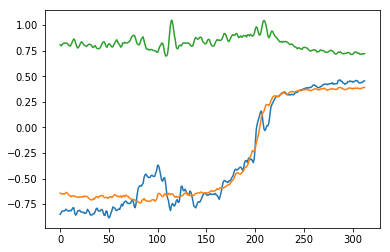

In [78]:
plt.plot(X[idx1][0][:,0:3])

## Train on Tremor

In [469]:
X = accn.copy()
y = scores_tremor.values
print(X.shape)
print(y.shape)

(27805, 313, 3)
(27805,)


In [474]:
#remove rows (tasks) for which bradykinesia scores do not exists
indok = np.where(~np.isnan(y))[0]
X = X[indok,:,:]
y = y[indok]
task = task[indok]
visit = visit[indok]
subj = subj[indok]

In [476]:
np.unique(task)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [477]:
print(X.shape)
print(y.shape)
print(task.shape)
print(visit.shape)
print(subj.shape)

(27532, 313, 3)
(27532,)
(27532,)
(27532,)
(27532,)


In [478]:
#binarize labels
y[y>0] = 1

In [479]:
sum(y>0)/len(y)

0.22784396338805754

In [480]:
#load clips, standardize and split data into train and valid set
def prepare_data(X,y,network_type,balance=False):
    
    #standardize all data (note - should std training and apply on test)
#     Xn = stdclipdata(X)
#     Xn = X
    
    #perform a random train_valid split first to test approach
    inds = np.arange(0,len(y))
    X_train,X_valid,y_train,y_valid,inds_train,inds_valid = train_test_split(X,y,inds,test_size=0.2,stratify=task,random_state=32)
    print('X_train = ')
    print(X_train.shape)
    print('X_valid = ')
    print(X_valid.shape)
    
    #balance training dataset
    if balance:
        indsp = np.where(y_train==1)[0]
        indsn = np.random.choice(np.where(y_train==0)[0],size=round(1.5*len(indsp)),replace=False)
        inds = np.hstack((indsp,indsn))
        X_train=X_train[inds]
        y_train=y_train[inds]

    num_classes = 2 # 
    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_valid = keras.utils.to_categorical(y_valid, num_classes)
    
    #format data for specific network
    _, win_len, dim = X.shape
    print('reshaping data for different models ...')
    X_train, X_valid = _data_reshaping(X_train, X_valid, network_type)
    print('X_train = ')
    print(X_train.shape)

    return X_train,y_train,X_valid,y_valid,inds_train,inds_valid,win_len,dim

In [481]:
X_train,y_train,X_valid,y_valid,inds_train,inds_valid,win_len,dim = prepare_data(X,y,'CNN')

X_train = 
(22025, 313, 3)
X_valid = 
(5507, 313, 3)
reshaping data for different models ...
CNN
X_train = 
(22025, 3, 313, 1)


In [482]:
#swap axes to have channel as last dim
X_train = np.swapaxes(X_train,1,3)
X_valid = np.swapaxes(X_valid,1,3)
print(X_train.shape)

(22025, 1, 313, 3)


In [483]:
#specifying hyper-parameters
batch_size = 512 #1024
feat_map_num = 16
num_classes =2 

In [484]:
print('building the model ...')
model=Sequential()
model.add(Conv2D(filters=16, kernel_size=(1, 32),activation='relu',input_shape=(1, win_len, dim),padding='same'))
model.add(MaxPooling2D(pool_size=(1, 4)))
model.add(Conv2D(filters=16, kernel_size=(1, 16), activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(1, 6)))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

building the model ...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 1, 313, 16)        1552      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 1, 78, 16)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 1, 78, 16)         4112      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 1, 13, 16)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 208)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                6688      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)              

In [485]:
print('model training ...')
epochs = 20
model.compile(loss=keras.losses.categorical_crossentropy,optimizer='adam',metrics=['accuracy'])
hist=model.fit(X_train,y_train,batch_size,epochs,shuffle=True,validation_data=(X_valid,y_valid))

model training ...
Train on 22025 samples, validate on 5507 samples
Epoch 1/20
22025/22025 [==============================] - 7s - loss: 0.5758 - acc: 0.7578 - val_loss: 0.4713 - val_acc: 0.7707
Epoch 2/20
22025/22025 [==============================] - 7s - loss: 0.4756 - acc: 0.7763 - val_loss: 0.4499 - val_acc: 0.7777
Epoch 3/20
22025/22025 [==============================] - 7s - loss: 0.4524 - acc: 0.7878 - val_loss: 0.4255 - val_acc: 0.8073
Epoch 4/20
22025/22025 [==============================] - 8s - loss: 0.4305 - acc: 0.8021 - val_loss: 0.4140 - val_acc: 0.8124
Epoch 5/20
22025/22025 [==============================] - 9s - loss: 0.4173 - acc: 0.8130 - val_loss: 0.4165 - val_acc: 0.8157
Epoch 6/20
22025/22025 [==============================] - 10s - loss: 0.4104 - acc: 0.8204 - val_loss: 0.3959 - val_acc: 0.8233
Epoch 7/20
22025/22025 [==============================] - 9s - loss: 0.3972 - acc: 0.8294 - val_loss: 0.3886 - val_acc: 0.8282
Epoch 8/20
22025/22025 [==================

f1_test=0.588, Prec=0.724, Rec=0.495, auprc=0.689
[[4004  239]
 [ 638  626]]
the mean f1 score:0.74


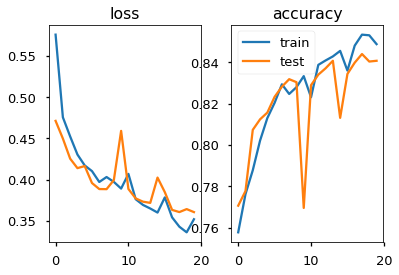

In [508]:
model_eval(X_valid,y_valid)

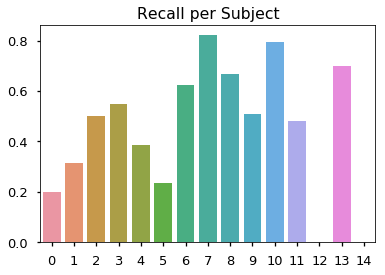

In [545]:
#recall rate per subject
y_pred = np.argmax(model.predict(X_valid),axis=1)
subj_valid=subj[inds_valid]

RecS = []
for s in np.unique(subj_valid):

    indS = np.where(subj_valid==s)
    ytrue_s = y_valid[indS]
    ypred_s = y_pred[indS]
    TP=sum(ypred_s[ytrue_s==1])
    P = sum(ytrue_s == 1)
    RecS.append(TP/P)
    
ax = sns.barplot(x=np.arange(len(RecS)),y=RecS)
plt.title('Recall per Subject')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text xticklabel objects>)

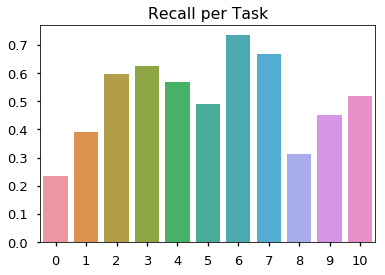

In [523]:
#recall rate per task
y_pred = np.argmax(model.predict(X_valid),axis=1)
y_valid = np.argmax(y_valid,axis=1)
task_valid=task[inds_valid]

RecS = []
for s in np.unique(task_valid):

    indS = np.where(task_valid==s)
    ytrue_s = y_valid[indS]
    ypred_s = y_pred[indS]
    TP=sum(ypred_s[ytrue_s==1])
    P = sum(ytrue_s == 1)
    RecS.append(TP/P)
    
ax = sns.barplot(x=np.unique(task_valid),y=RecS)
plt.title('Recall per Task')
plt.xticks()

In [60]:
tasklist=(list(zip(taskcodes,tasknames)))

NameError: name 'taskcodes' is not defined

In [639]:
print(tasklist)

[(0, 'Motor #10: Drinking Water'), (1, 'Motor #11: Organizing Folder'), (2, 'Motor #12: Folding Towels'), (3, 'Motor #2: Walking'), (4, 'Motor #3: Walking while Counting'), (5, 'Motor #4: Finger to Nose'), (6, 'Motor #5: Alternating Hand Movements'), (7, 'Motor #6: Sit to Stand'), (8, 'Motor #7: Drawing on Paper'), (9, 'Motor #8: Typing on a Computer'), (10, 'Motor #9: Nuts and Bolts')]


In [539]:
indscorrect=inds_valid[y_valid==y_pred]
indswrong=inds_valid[y_valid!=y_pred]

In [543]:
len(indswrong)

877

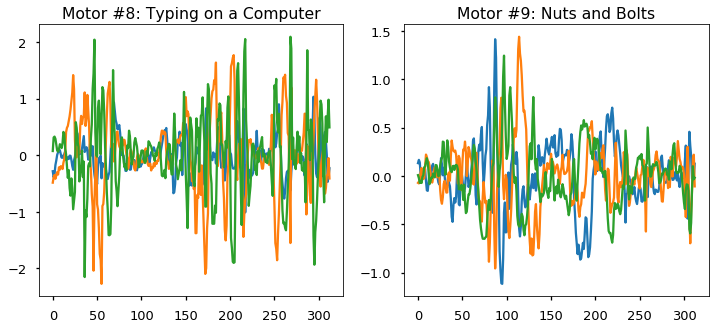

In [640]:
idx1 = np.random.choice(indswrong,size=1)
idx2 = np.random.choice(indscorrect,size=1)
fig=plt.figure(figsize=(12,5))
fig.add_subplot(121)
plt.plot(X[idx1][0])
plt.title(tasklist[int(task[idx1])][1])
fig.add_subplot(122)
plt.plot(X[idx2][0])
plt.title(tasklist[int(task[idx2])][1])

** One problem is that we do not know where the symptom shows in the entire recording**

## Train on entire recordings

In [11]:
Data = pd.read_csv('../FeatureMatrix/DataFullRec.csv')
Data.head(3)

,Unnamed: 0,Subject,Visit,Task,Location,Bradykinesia,Tremor,RMSX,RMSY,RMSZ,...,PSD_std,PSD_skew,PSD_kur,jerk_mean,jerk_std,jerk_skew,jerk_kur,Sen_X,Sen_Y,Sen_Z
0,0,1004,2 Weeks: Time 0,Motor #2: Walking,dorsal_hand_left,1.0,0.0,0.002610,0.003850,0.002191,...,0.000877,1.680997,2.118982,0.000010,0.028629,-0.256309,8.984299,0.676526,0.625630,0.630607
1,0,1004,2 Weeks: Time 30,Motor #2: Walking,dorsal_hand_left,0.0,0.0,0.003935,0.004898,0.003074,...,0.001397,0.962419,-0.373278,-0.000018,0.041619,-0.352026,12.063202,0.654396,0.694583,0.616817
2,0,1004,2 Weeks: Time 60,Motor #2: Walking,dorsal_hand_left,0.0,0.0,0.005156,0.007520,0.003912,...,0.004366,1.755201,3.318823,0.000038,0.046787,-0.069417,6.359663,0.570756,0.630046,0.575315


In [16]:
len(Data)

2376

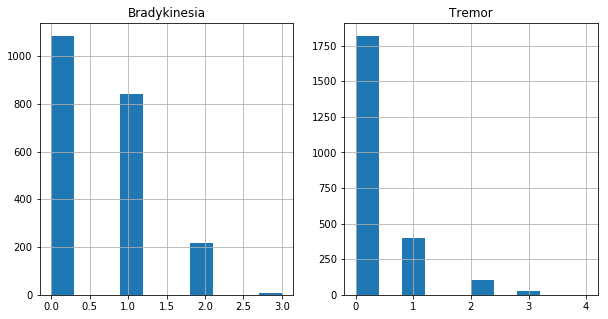

In [12]:
fig = plt.figure(figsize=(10,5))
fig.add_subplot(121)
Data['Bradykinesia'].hist()
plt.title('Bradykinesia')
fig.add_subplot(122)
Data['Tremor'].hist()
plt.title('Tremor')

In [13]:
symptom = 'Bradykinesia'
indp = ((Data[symptom]>0))

In [15]:
#LOSO CV
groups = Data.Subject.as_matrix()

In [27]:
groups

array([1004, 1004, 1004, ..., 1051, 1051, 1051])

In [20]:
#standardize features (should be done in the CV loop)
X = Data.iloc[:,7:]
X_std = StandardScaler().fit_transform(X)
print(X_std.shape)

(2376, 37)


In [25]:
t1=time.time()

for symptom in ['Tremor','Bradykinesia']:
    
    indp = ((Data[symptom]>0)) #binarize
    indp = indp.values
    y = indp.astype(int) #target 
    print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

    models = [RandomForestClassifier(n_estimators=100,random_state=2),          
          XGBClassifier()]
    model_name = ['Random Forest','XGB']
    models = list(zip(models,model_name))

    LOSOCV(Data,X_std,y,groups,models)
    
print('Elapsed time = %.3f'%(round(time.time()-t1)))    

Rows w Tremor 529/2376 = 0.22
Training Random Forest

Subj 0, prec=0.167, rec=0.118

Subj 1, prec=0.667, rec=0.048

Subj 2, prec=0.857, rec=0.214

Subj 3, prec=0.360, rec=0.692

Subj 4, prec=0.333, rec=0.200

Subj 5, prec=0.250, rec=0.048

Subj 6, prec=0.594, rec=0.275

Subj 7, prec=0.824, rec=0.538

Subj 8, prec=0.400, rec=0.087

Subj 9, prec=0.926, rec=0.231

Subj 10, prec=0.842, rec=0.842

Subj 11, prec=0.200, rec=0.045

Subj 12, prec=0.000, rec=0.000

Subj 13, prec=0.794, rec=0.380

Subj 14, prec=0.000, rec=0.000
f1_test=0.290+/-0.242, prec=0.481+/-0.313, rec=0.248+/-0.251, auprc=0.469+/-0.283
Training XGB

Subj 0, prec=0.176, rec=0.176

Subj 1, prec=0.714, rec=0.060

Subj 2, prec=0.667, rec=0.214

Subj 3, prec=0.296, rec=0.615

Subj 4, prec=0.333, rec=0.200

Subj 5, prec=0.250, rec=0.095

Subj 6, prec=0.553, rec=0.304

Subj 7, prec=0.846, rec=0.423

Subj 8, prec=0.500, rec=0.217

Subj 9, prec=0.923, rec=0.222

Subj 10, prec=0.667, rec=0.632

Subj 11, prec=0.143, rec=0.045

Subj 12

In [36]:
scores = []
for s in Data.Subject.unique():
    scores.append(Data.loc[Data['Subject']==s,'Bradykinesia'].max())

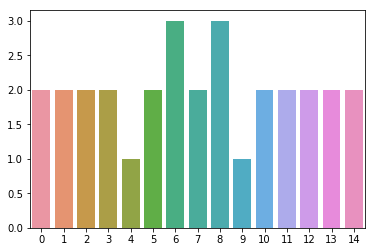

In [37]:
sns.barplot(x=np.arange(len(Data.Subject.unique())),y=scores)

In [47]:
for symptom in ['Tremor','Bradykinesia']:
    
    indp = ((Data[symptom]>0))
    indp = indp.values
    y = indp.astype(int) #target 
    print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

    models = [RandomForestClassifier(n_estimators=100,random_state=2)]
    model_name = ['Random Forest']
    models = list(zip(models,model_name))

    f1_fold_clf, auc_fold_clf, cmats = trainmodel_Kfold(X_std,y,models,nfolds=5,balance=False)
    
print('Elapsed time = %.3f'%(round(time.time()-t1)))    

Rows w Tremor 529/2376 = 0.22
Random Forest
f1_train=1.000+/-0.000, f1_test=0.550+/-0.056, prec=0.826+/-0.084, rec=0.414+/-0.050, auprc=0.733+/-0.067
[[359  10]
 [ 60  45]]
Rows w Bradykinesia 1068/2376 = 0.45
Random Forest
f1_train=1.000+/-0.000, f1_test=0.755+/-0.015, prec=0.777+/-0.006, rec=0.735+/-0.026, auprc=0.837+/-0.017
[[216  45]
 [ 60 153]]
Elapsed time = 9152.000


## Feature importance

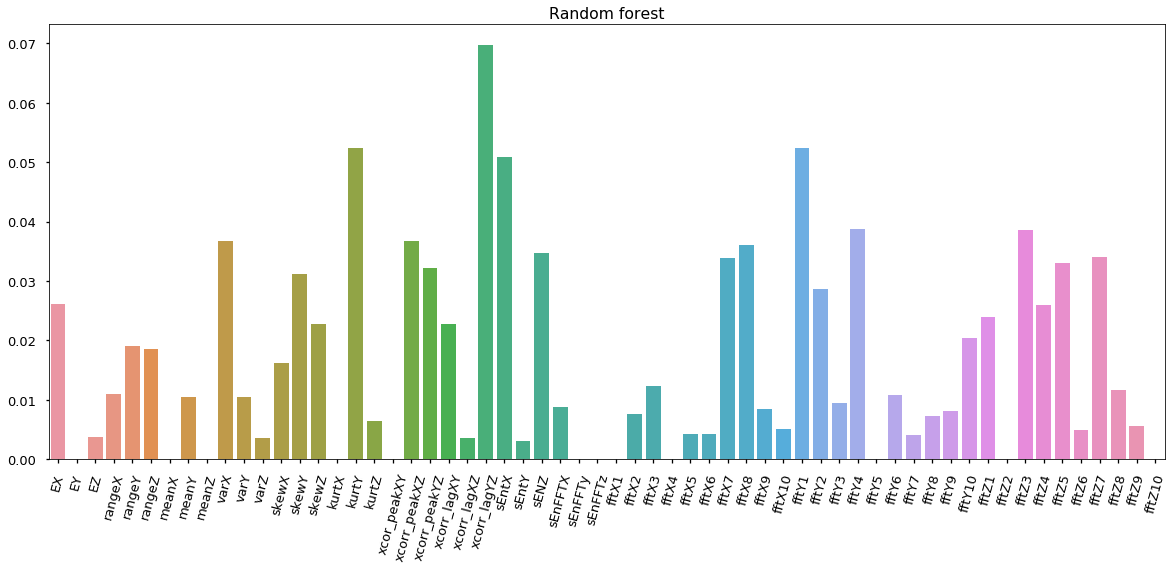

In [181]:
clf = models[1][0]
fimp = pd.Series(index=Data.columns[7:],data=clf.feature_importances_)
plt.figure(figsize=(20,8))
ax = sns.barplot(x=fimp.index,y=fimp.values)
_ = plt.xticks(rotation=75)
plt.title('Random forest')